In [28]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os, gc
import math, random
import pickle
import datetime, time
from tqdm import tqdm_notebook as tqdm

import torch 
from torch import nn
from torch import optim

from sklearn import preprocessing
from sklearn.cluster import KMeans

%matplotlib inline

In [2]:
path = '/Users/kanoumotoharu/Downloads/m5-forecasting-accuracy/'

In [3]:
os.listdir(path)

['calendar.csv',
 'sell_prices.csv',
 'sales_train_validation.csv',
 'sample_submission.csv']

In [4]:
%%time
train_df = pd.read_csv(path+'sales_train_validation.csv')
calendar_df = pd.read_csv(path+'calendar.csv')
sell_prices_df = pd.read_csv(path+'sell_prices.csv')
sample_submission_df = pd.read_csv(path+'sample_submission.csv')

CPU times: user 12.2 s, sys: 1.13 s, total: 13.4 s
Wall time: 13.4 s


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


In [6]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
date            1969 non-null object
wm_yr_wk        1969 non-null int64
weekday         1969 non-null object
wday            1969 non-null int64
month           1969 non-null int64
year            1969 non-null int64
d               1969 non-null object
event_name_1    162 non-null object
event_type_1    162 non-null object
event_name_2    5 non-null object
event_type_2    5 non-null object
snap_CA         1969 non-null int64
snap_TX         1969 non-null int64
snap_WI         1969 non-null int64
dtypes: int64(7), object(7)
memory usage: 215.4+ KB


In [7]:
sell_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
store_id      object
item_id       object
wm_yr_wk      int64
sell_price    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [8]:
train_df.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4   ...    d_1904  d_1905  d_1906  d_1907  \
0       CA    0    0    0    0   ...         1       3       0       1   
1       CA    0    0    0    0   ...         0       0       0       0   
2       CA    0    0    0    0   ...         2       1       2       1   
3       CA    0    0    0    0   ...         1       0       5       4   
4       CA    0    0    0    0   ...         2       1       1       0   

   d_1908  d_1909  d_1910  d_1911  d_1912  d_1913  
0       1       1       3       0       1       1  
1       0       1       0       0       0       0  
2       1       1       0       1       1       1  
3       1       0       1       3       7       2  
4       1       1       2       2       2       4  

[5 rows x 1919 columns]

In [9]:
train_df.store_id.nunique()

10

In [10]:
calendar_df.head()

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

In [11]:
sell_prices_df['date'] = sell_prices_df['wm_yr_wk'].map(calendar_df.set_index('wm_yr_wk')['date'].to_dict())
sell_prices_df['id'] = sell_prices_df['item_id'].astype('str')+'_'+sell_prices_df['store_id']+'_validation'
sell_prices_df.head()

store_id        item_id  wm_yr_wk  sell_price        date  \
0     CA_1  HOBBIES_1_001     11325        9.58  2013-07-19   
1     CA_1  HOBBIES_1_001     11326        9.58  2013-07-26   
2     CA_1  HOBBIES_1_001     11327        8.26  2013-08-02   
3     CA_1  HOBBIES_1_001     11328        8.26  2013-08-09   
4     CA_1  HOBBIES_1_001     11329        8.26  2013-08-16   

                              id  
0  HOBBIES_1_001_CA_1_validation  
1  HOBBIES_1_001_CA_1_validation  
2  HOBBIES_1_001_CA_1_validation  
3  HOBBIES_1_001_CA_1_validation  
4  HOBBIES_1_001_CA_1_validation

In [12]:
d_cols = [f'd_{i}' for i in range(1,1914)]

In [13]:
data = train_df.set_index('id')[d_cols].T
data.reset_index(drop=True, inplace=True)

In [14]:
data.head()

id  HOBBIES_1_001_CA_1_validation  HOBBIES_1_002_CA_1_validation  \
0                               0                              0   
1                               0                              0   
2                               0                              0   
3                               0                              0   
4                               0                              0   

id  HOBBIES_1_003_CA_1_validation  HOBBIES_1_004_CA_1_validation  \
0                               0                              0   
1                               0                              0   
2                               0                              0   
3                               0                              0   
4                               0                              0   

id  HOBBIES_1_005_CA_1_validation  HOBBIES_1_006_CA_1_validation  \
0                               0                              0   
1                               0                              0   
2                               0                              0   
3                               0                              0   
4                               0                              0   

id  HOBBIES_1_007_CA_1_validation  HOBBIES_1_008_CA_1_validation  \
0                               0                             12   
1                               0                             15   
2                               0                              0   
3                               0                              0   
4                               0                              0   

id  HOBBIES_1_009_CA_1_validation  HOBBIES_1_010_CA_1_validation  \
0                               2                              0   
1                               0                              0   
2                               7                              1   
3                               3                              0   
4                               0                              0   

id             ...               FOODS_3_818_WI_3_validation  \
0              ...                                         0   
1              ...                                         0   
2              ...                                         0   
3              ...                                         0   
4              ...                                         0   

id  FOODS_3_819_WI_3_validation  FOODS_3_820_WI_3_validation  \
0                            14                            1   
1                            11                            1   
2                             5                            1   
3                             6                            1   
4                             5                            1   

id  FOODS_3_821_WI_3_validation  FOODS_3_822_WI_3_validation  \
0                             0                            4   
1                             0                            4   
2                             0                            2   
3                             0                            5   
4                             0                            2   

id  FOODS_3_823_WI_3_validation  FOODS_3_824_WI_3_validation  \
0                             0                            0   
1                             0                            0   
2                             2                            0   
3                             2                            0   
4                             0                            0   

id  FOODS_3_825_WI_3_validation  FOODS_3_826_WI_3_validation  \
0                             0                            0   
1                             6                            0   
2                             0                            0   
3                             2                            0   
4                             2                            0   

id  FOODS_3_827_WI_3_validatio

In [15]:
data = pd.concat([
    calendar_df[['date', 'wm_yr_wk', 'weekday', 'event_name_1', 'event_type_1', 'event_name_2',
                 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI']],
    data
],axis=1)

In [16]:
data.head()

date  wm_yr_wk    weekday event_name_1 event_type_1 event_name_2  \
0  2011-01-29     11101   Saturday          NaN          NaN          NaN   
1  2011-01-30     11101     Sunday          NaN          NaN          NaN   
2  2011-01-31     11101     Monday          NaN          NaN          NaN   
3  2011-02-01     11101    Tuesday          NaN          NaN          NaN   
4  2011-02-02     11101  Wednesday          NaN          NaN          NaN   

  event_type_2  snap_CA  snap_TX  snap_WI             ...               \
0          NaN        0        0        0             ...                
1          NaN        0        0        0             ...                
2          NaN        0        0        0             ...                
3          NaN        1        1        0             ...                
4          NaN        1        0        1             ...                

   FOODS_3_818_WI_3_validation  FOODS_3_819_WI_3_validation  \
0                          0.0                         14.0   
1                          0.0                         11.0   
2                          0.0                          5.0   
3                          0.0                          6.0   
4                          0.0                          5.0   

   FOODS_3_820_WI_3_validation  FOODS_3_821_WI_3_validation  \
0                          1.0                          0.0   
1                          1.0                          0.0   
2                          1.0                          0.0   
3                          1.0                          0.0   
4                          1.0                          0.0   

   FOODS_3_822_WI_3_validation  FOODS_3_823_WI_3_validation  \
0                          4.0                          0.0   
1                          4.0                          0.0   
2                          2.0                          2.0   
3                          5.0                          2.0   
4                          2.0                          0.0   

   FOODS_3_824_WI_3_validation  FOODS_3_825_WI_3_validation  \
0                          0.0                          0.0   
1                          0.0                          6.0   
2                          0.0                          0.0   
3                          0.0                          2.0   
4                          0.0                          2.0   

   FOODS_3_826_WI_3_validation  FOODS_3_827_WI_3_validation  
0                          0.0                          0.0  
1                          0.0                          0.0  
2                          0.0                          0.0  
3                          0.0                          0.0  
4                          0.0                          0.0  

[5 rows x 30500 columns]

In [17]:
for col in ['weekday', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']:
    data = pd.concat([
        data.drop(col, axis=1),
        pd.get_dummies(data[col])
    ], axis=1)

In [18]:
data.head(10)

date  wm_yr_wk  snap_CA  snap_TX  snap_WI  \
0  2011-01-29     11101        0        0        0   
1  2011-01-30     11101        0        0        0   
2  2011-01-31     11101        0        0        0   
3  2011-02-01     11101        1        1        0   
4  2011-02-02     11101        1        0        1   
5  2011-02-03     11101        1        1        1   
6  2011-02-04     11101        1        0        0   
7  2011-02-05     11102        1        1        1   
8  2011-02-06     11102        1        1        1   
9  2011-02-07     11102        1        1        0   

   HOBBIES_1_001_CA_1_validation  HOBBIES_1_002_CA_1_validation  \
0                            0.0                            0.0   
1                            0.0                            0.0   
2                            0.0                            0.0   
3                            0.0                            0.0   
4                            0.0                            0.0   
5                            0.0                            0.0   
6                            0.0                            0.0   
7                            0.0                            0.0   
8                            0.0                            0.0   
9                            0.0                            0.0   

   HOBBIES_1_003_CA_1_validation  HOBBIES_1_004_CA_1_validation  \
0                            0.0                            0.0   
1                            0.0                            0.0   
2                            0.0                            0.0   
3                            0.0                            0.0   
4                            0.0                            0.0   
5                            0.0                            0.0   
6                            0.0                            0.0   
7                            0.0                            0.0   
8                            0.0                            0.0   
9                            0.0                            0.0   

   HOBBIES_1_005_CA_1_validation    ...      Cultural  National  Religious  \
0                            0.0    ...             0         0          0   
1                            0.0    ...             0         0          0   
2                            0.0    ...             0         0          0   
3                            0.0    ...             0         0          0   
4                            0.0    ...             0         0          0   
5                            0.0    ...             0         0          0   
6                            0.0    ...             0         0          0   
7                            0.0    ...             0         0          0   
8                            0.0    ...             0         0          0   
9                            0.0    ...             0         0          0   

   Sporting  Cinco De Mayo  Easter  Father's day  OrthodoxEaster  Cultural  \
0         0              0       0             0               0         0   
1         0              0       0             0               0         0   
2         0              0       0             0               0         0   
3         0              0       0             0               0         0   
4         0              0       0             0               0         0   
5         0              0       0             0               0         0   
6         0              0       0             0               0         0   
7         0              0       0             0               0         0   
8         1              0       0             0               0         0   
9         0              0       0             0               0         0   

   Religious  
0          0  
1          0  
2          0  
3          0  
4          0  
5          0  
6          0  
7          0  
8          0  
9          0  

[10 rows x 30542 columns]

In [19]:
def data_maker(df, prices_df, columns, features):
    tensor_data=[]
    for column in tqdm(columns):
        tmp_df = df[['wm_yr_wk', column]+features]
        tmp_prices_df = prices_df[prices_df.id==column]
        tmp_prices_df = tmp_prices_df.set_index('wm_yr_wk')['sell_price']#.to_dict()
        tmp_df['sell_price'] = tmp_df['wm_yr_wk'].map(tmp_prices_df)
        tmp_df['sell_price'] = tmp_df['sell_price'].fillna(-1)
        
        #tmp_df = tmp_df[:1913]
        tensor_data.append(tmp_df.values[:,1:].tolist())
    return tensor_data

In [20]:
data.columns[-47:]

Index(['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday', 'Chanukah End', 'Christmas', 'Cinco De Mayo',
       'ColumbusDay', 'Easter', 'Eid al-Fitr', 'EidAlAdha', 'Father's day',
       'Halloween', 'IndependenceDay', 'LaborDay', 'LentStart', 'LentWeek2',
       'MartinLutherKingDay', 'MemorialDay', 'Mother's day', 'NBAFinalsEnd',
       'NBAFinalsStart', 'NewYear', 'OrthodoxChristmas', 'OrthodoxEaster',
       'Pesach End', 'PresidentsDay', 'Purim End', 'Ramadan starts',
       'StPatricksDay', 'SuperBowl', 'Thanksgiving', 'ValentinesDay',
       'VeteransDay', 'Cultural', 'National', 'Religious', 'Sporting',
       'Cinco De Mayo', 'Easter', 'Father's day', 'OrthodoxEaster', 'Cultural',
       'Religious'],
      dtype='object')

In [21]:
columns = data.columns[5:-47].tolist()
features = data.columns[-47:].tolist()

In [22]:
columns = random.sample(columns, 1000)

In [23]:
input_data = data[-int(365*2):1913]
input_data.shape

(674, 30542)

In [24]:
input_sell_prices_df = sell_prices_df[sell_prices_df.wm_yr_wk.isin(input_data.wm_yr_wk.unique())]

In [25]:
data_tensor = data_maker(input_data, input_sell_prices_df, columns, features)

In [26]:
gc.collect()

17

In [43]:
class Autoencorder_1d(nn.Module):

    def __init__(self, input_size, dim_num):
        super(Autoencorder_1d, self).__init__()
        
        size_1 = input_size
        size_2 = int(size_1/2.5) if int(size_1/2.5)<1 else 20
        size_3 = int(size_1/5) if int(size_1/5)<1 else 10
        
        
        self.encorder = nn.Sequential(
            nn.Conv1d(size_1, size_2, 7),
            nn.GELU(),
            nn.Conv1d(size_2, size_3, 7)
        )
        
        self.lin = nn.Linear(size_3, dim_num)
        
        self.avgpool1d = nn.AdaptiveAvgPool1d(1)
        
        self.decorder = nn.Sequential(
            nn.Linear(dim_num, size_3),
            nn.GELU(),
            nn.Linear(size_3, size_2),
            nn.GELU(),
            nn.Linear(size_2, size_1)
        ) 

    def forward(self, x):
        x = self.encorder(x)
        x = self.avgpool1d(x)
        x = torch.flatten(x, 1)
        #print(x.size())
        x1 = self.lin(x)
        x = self.decorder(x1)

        return x1, x

In [39]:
data_tensor = torch.FloatTensor(data_tensor)
true = torch.FloatTensor(input_data[columns].T.values)
data_tensor.size(), true.size()

(torch.Size([1000, 674, 61]), torch.Size([1000, 674]))

In [71]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [72]:
train_data = data_tensor[:800, :, :]
val_data = data_tensor[800:, : , :]
train_true = true[:800,:]
val_true = true[800:,:]

In [73]:
val_data = val_data.to(device)
val_true = val_true.to(device)

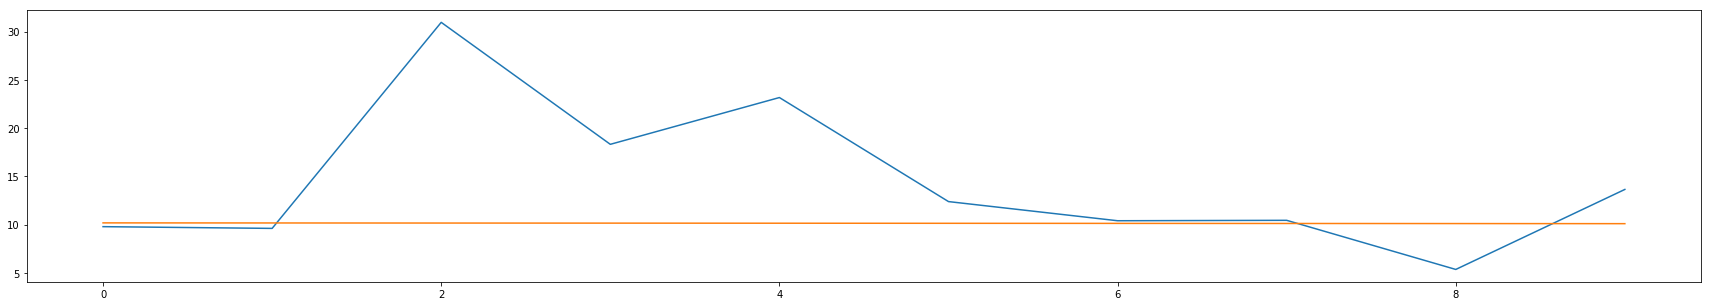

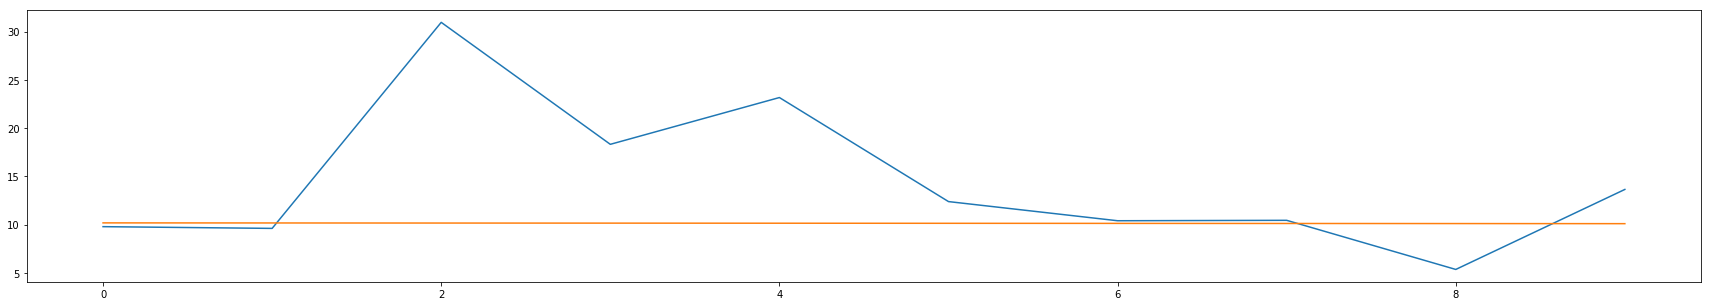

In [74]:
model = Autoencorder_1d(674, 2)
optimizer = optim.Adam(params=model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

loss_list=[]
val_loss_list = []
for epoch in tqdm(range(70000)):
    try:
        model.train()
        index = random.sample([i for i in range(800)], 130)

        tmp_train_data = train_data[index, :,:].to(device)
        tmp_train_true = train_true[index, :].to(device)
        out1, out2 = model(tmp_train_data)
        loss = criterion(out2, tmp_train_true)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_list.append(loss.item())

        model.eval()
        out1, out2 = model(val_data)
        loss = criterion(out2, val_true)
        val_loss_list.append(loss.item())
        
        if epoch%500==0 and epoch>0:
            plt.figure(figsize=(30,5))
            plt.plot(loss_list)
            plt.plot(val_loss_list)
            plt.show()
    except:
        model.eval()
        out1, out2 = model(val_data)
        loss = criterion(out2, val_true)
        break
    
plt.figure(figsize=(30,5))
plt.plot(loss_list)
plt.plot(val_loss_list)
plt.show()

plt.figure(figsize=(30,5))
plt.plot(loss_list[-50:])
plt.plot(val_loss_list[-50:])
plt.show()

In [75]:
out1 = out1.cpu().detach().numpy()
out2 = out2.cpu().detach().numpy()
val_true = val_true.cpu().detach().numpy()

In [76]:
out1.shape

(200, 2)

In [77]:
k = KMeans(25)
label = k.fit_predict(out1)

df = pd.DataFrame()
df['out1'] = out1[:,0]
df['out2'] = out1[:,1]
df['label'] =label
df['column'] = columns[800:]
df.head()

out1      out2  label                           column
0 -1.299406  0.184778     10      FOODS_3_524_TX_2_validation
1 -1.227477  0.248409      0      FOODS_3_016_CA_4_validation
2 -1.387197  0.307132      7  HOUSEHOLD_2_307_WI_2_validation
3 -1.415784  0.302287      7  HOUSEHOLD_1_366_TX_3_validation
4 -1.113716  0.221289      5    HOBBIES_1_145_WI_2_validation

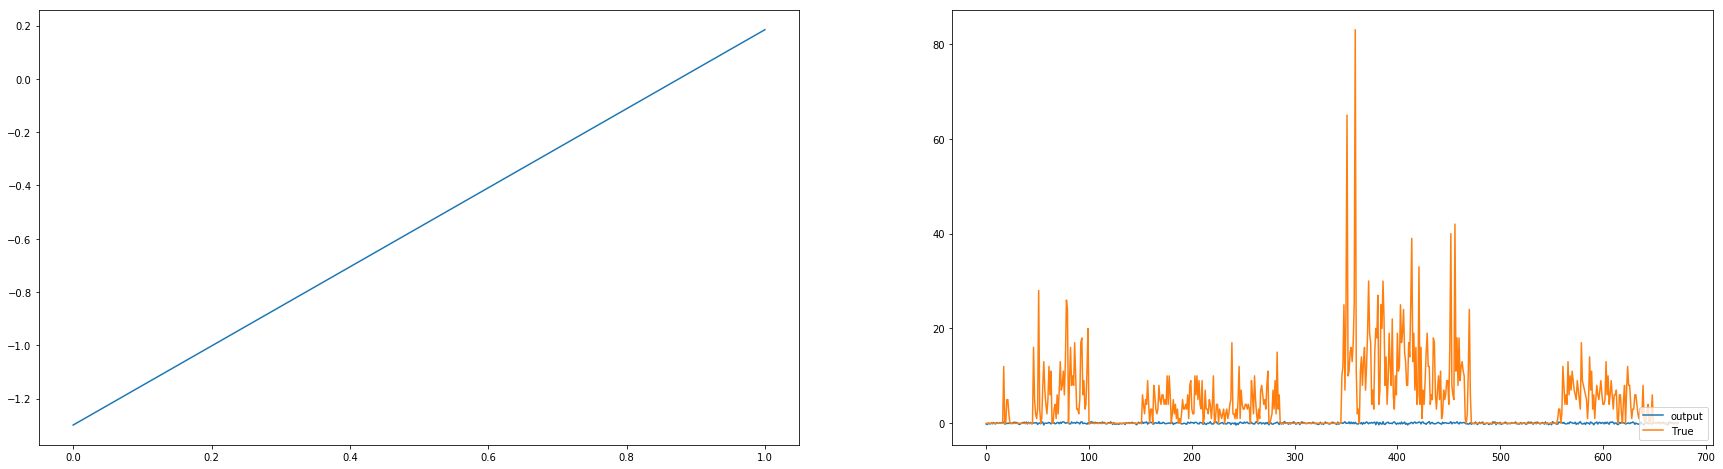

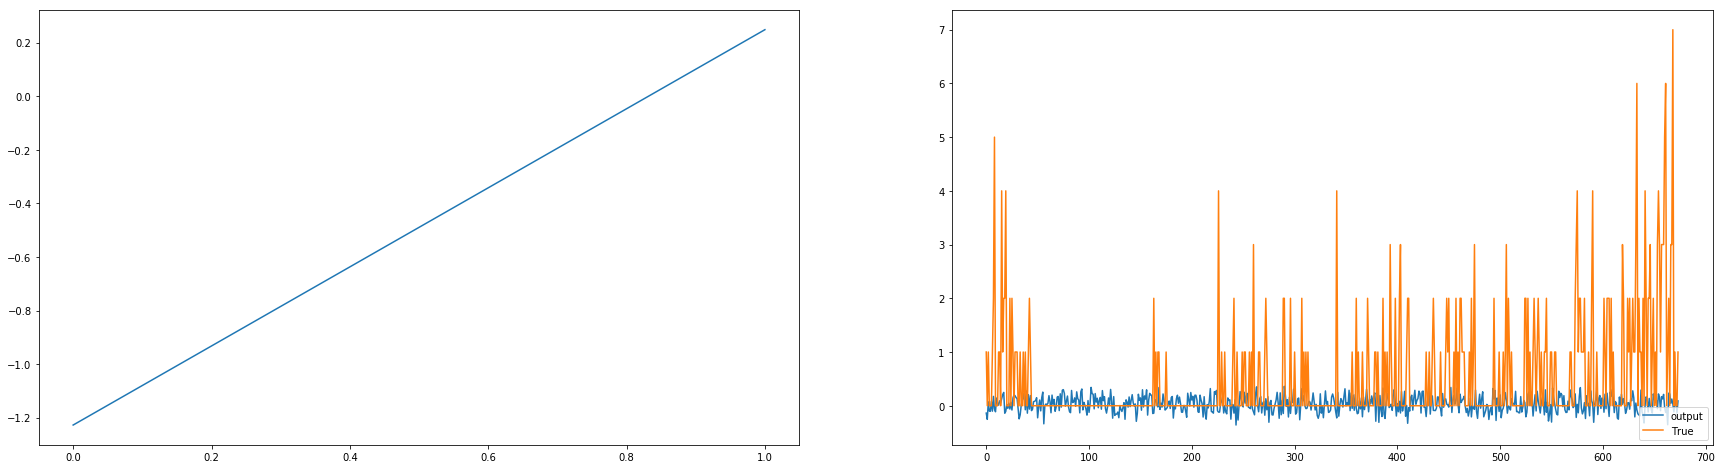

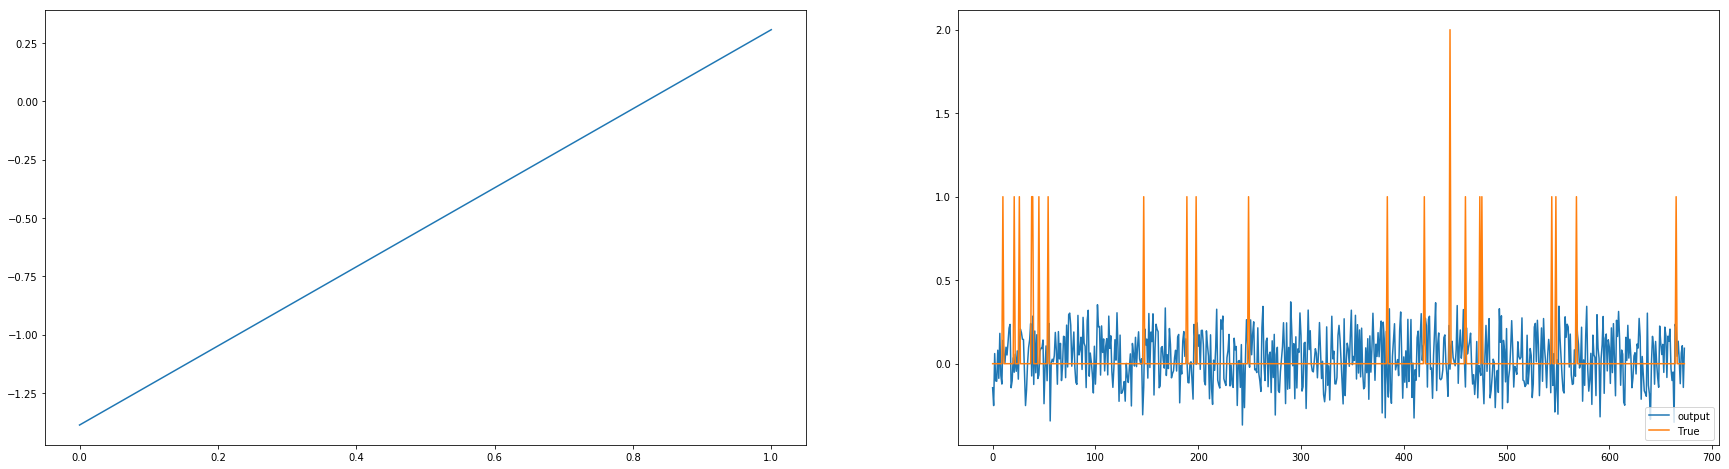

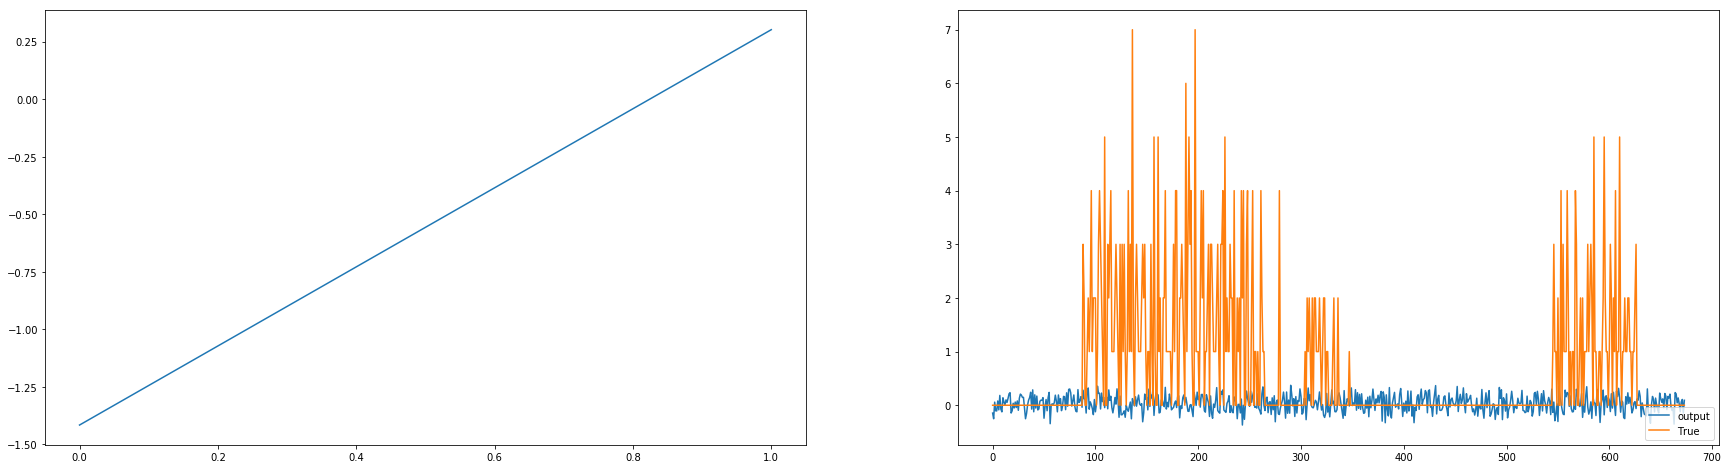

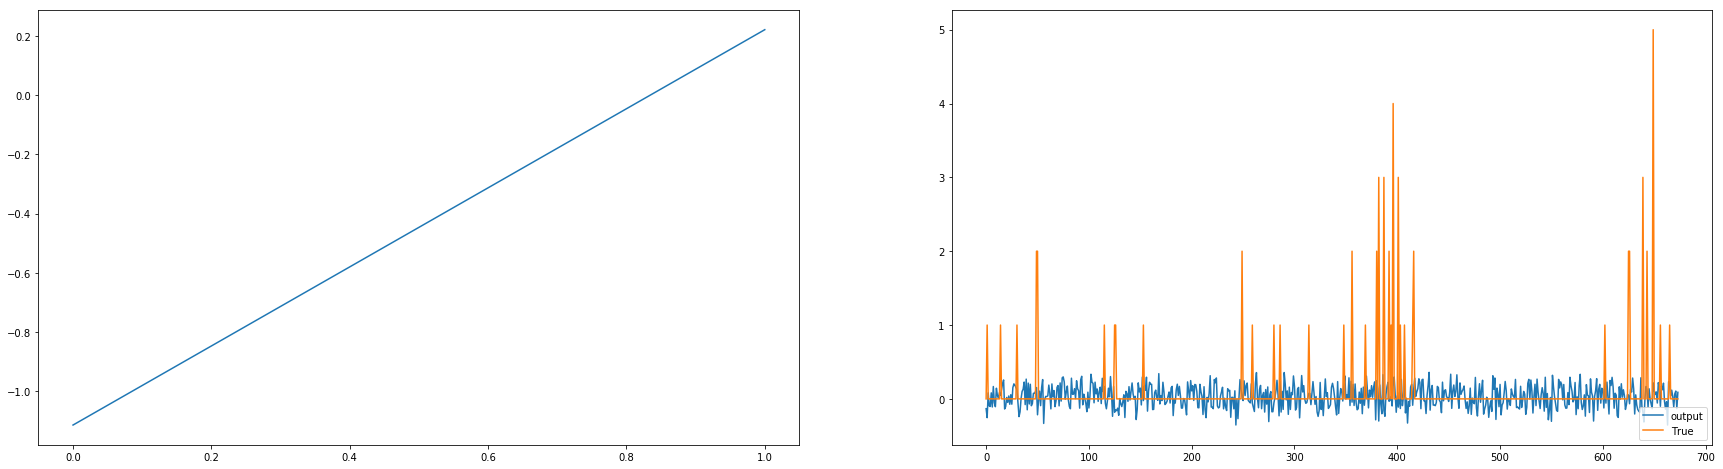

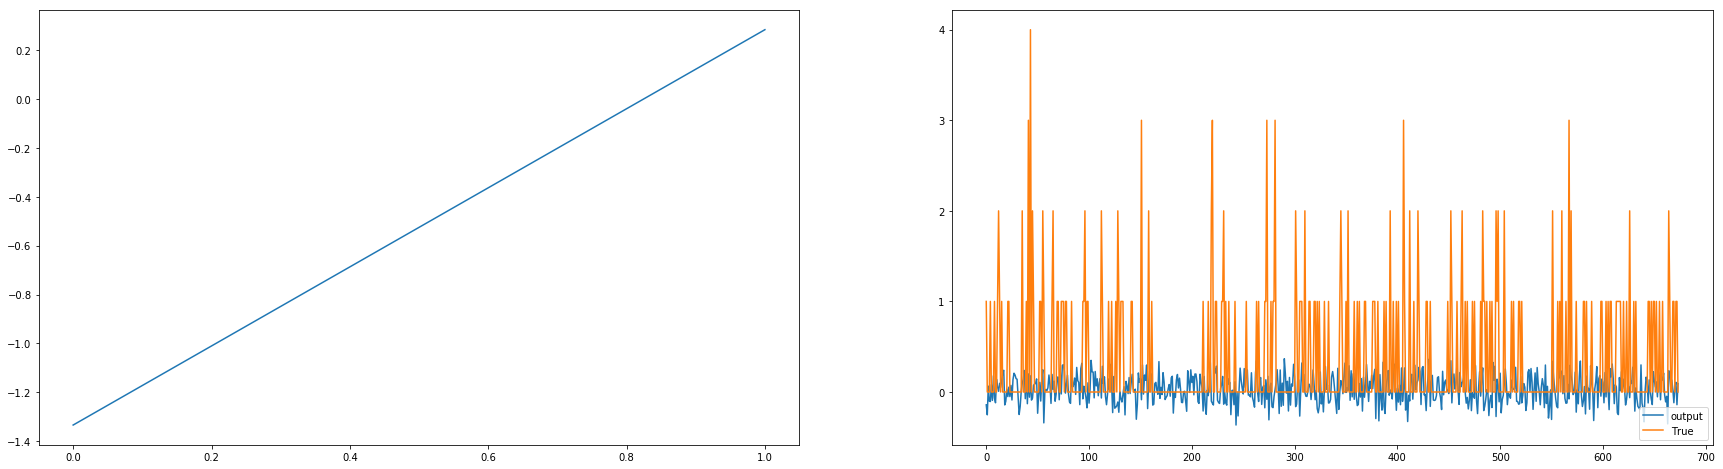

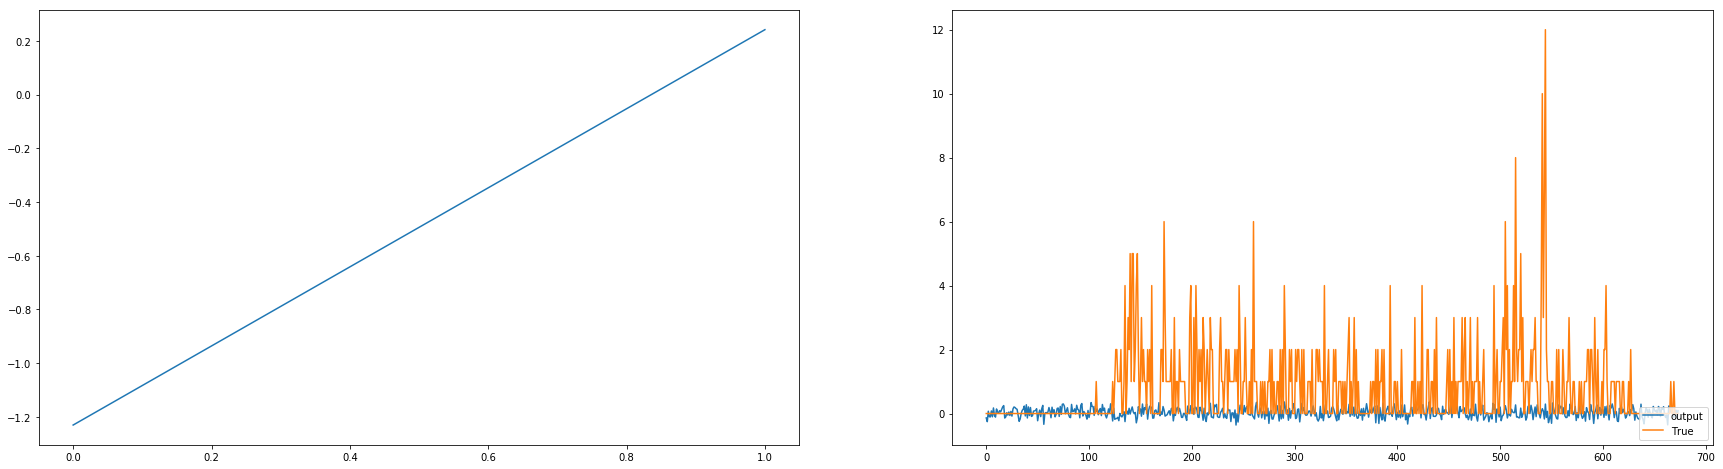

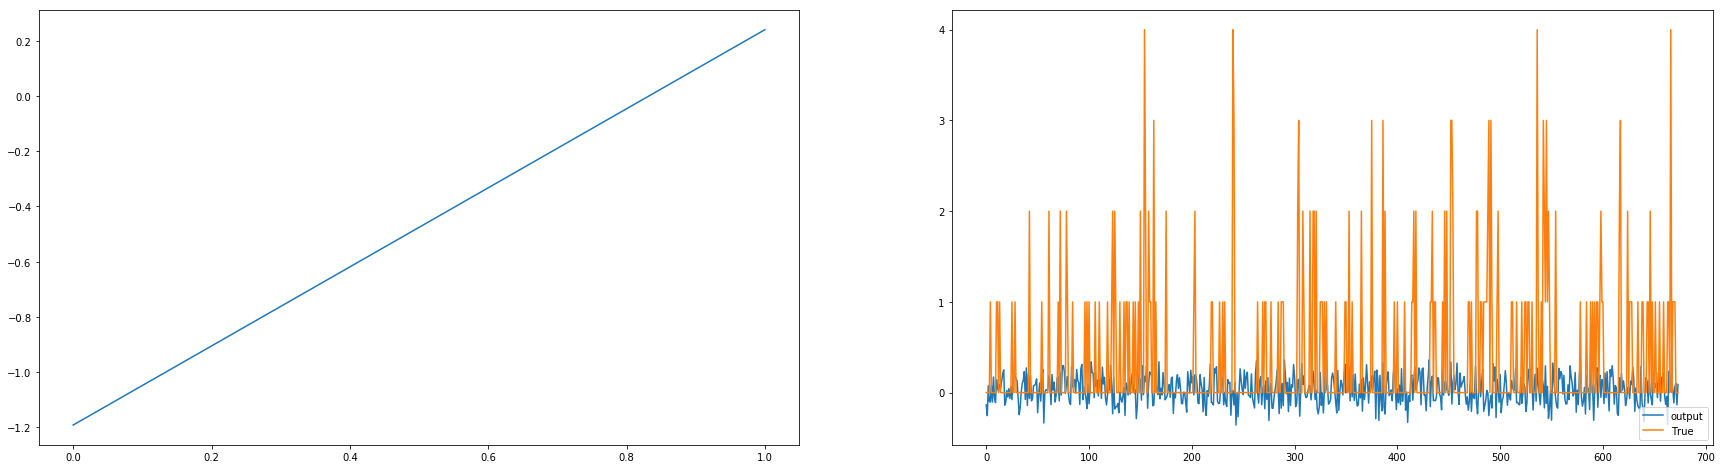

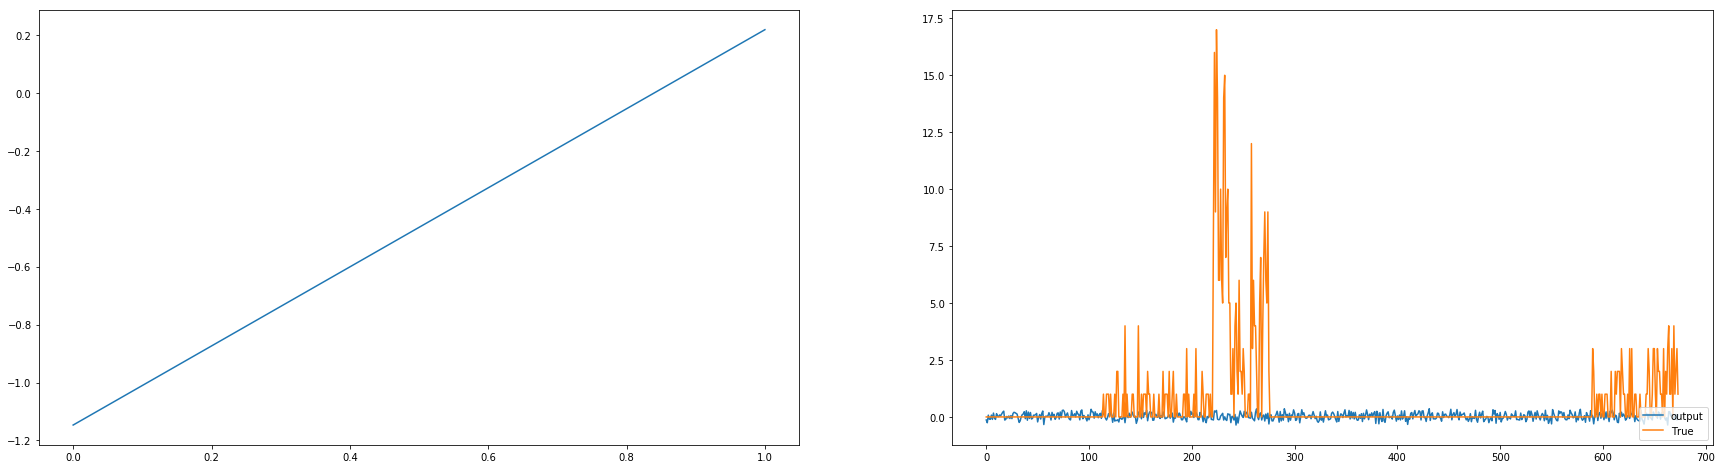

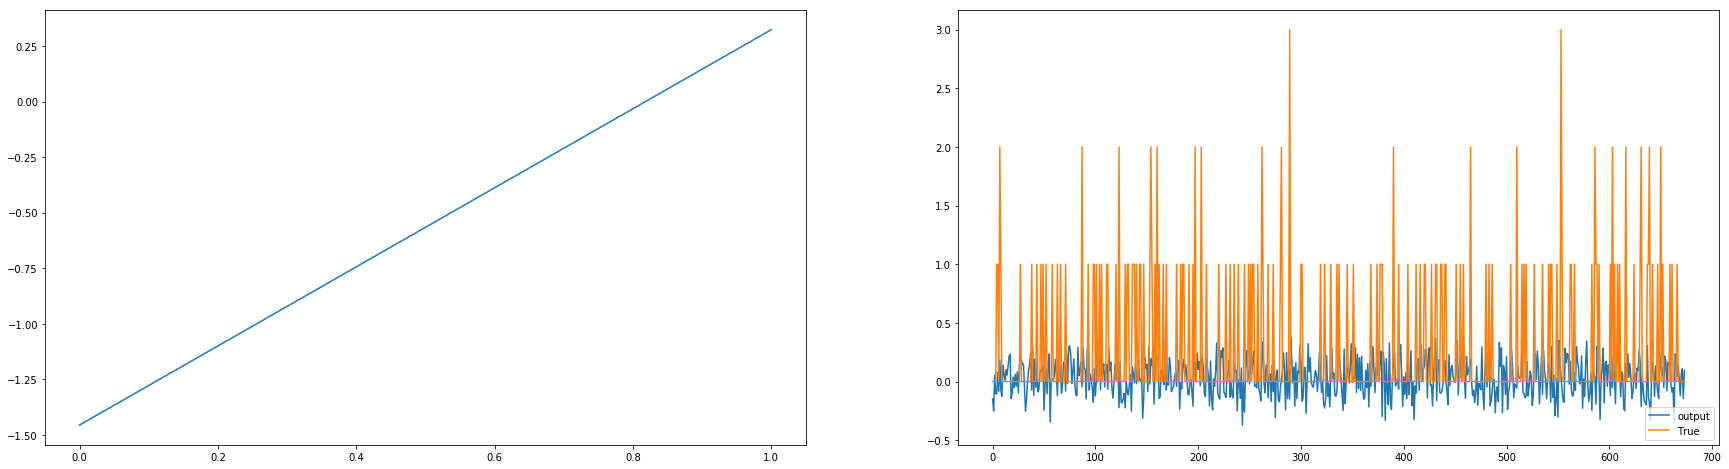

In [78]:
for i in range(10):
    tmp_out1 = out1[i]
    tmp_out2 = out2[i]
    _true = val_true[i]


    plt.figure(figsize=(30,8))
    plt.subplot(1,2,1)
    plt.plot(tmp_out1)
    plt.subplot(1,2,2)
    plt.plot(tmp_out2, label='output')
    plt.plot(_true, label='True')
    plt.legend(loc=4)
    plt.show()

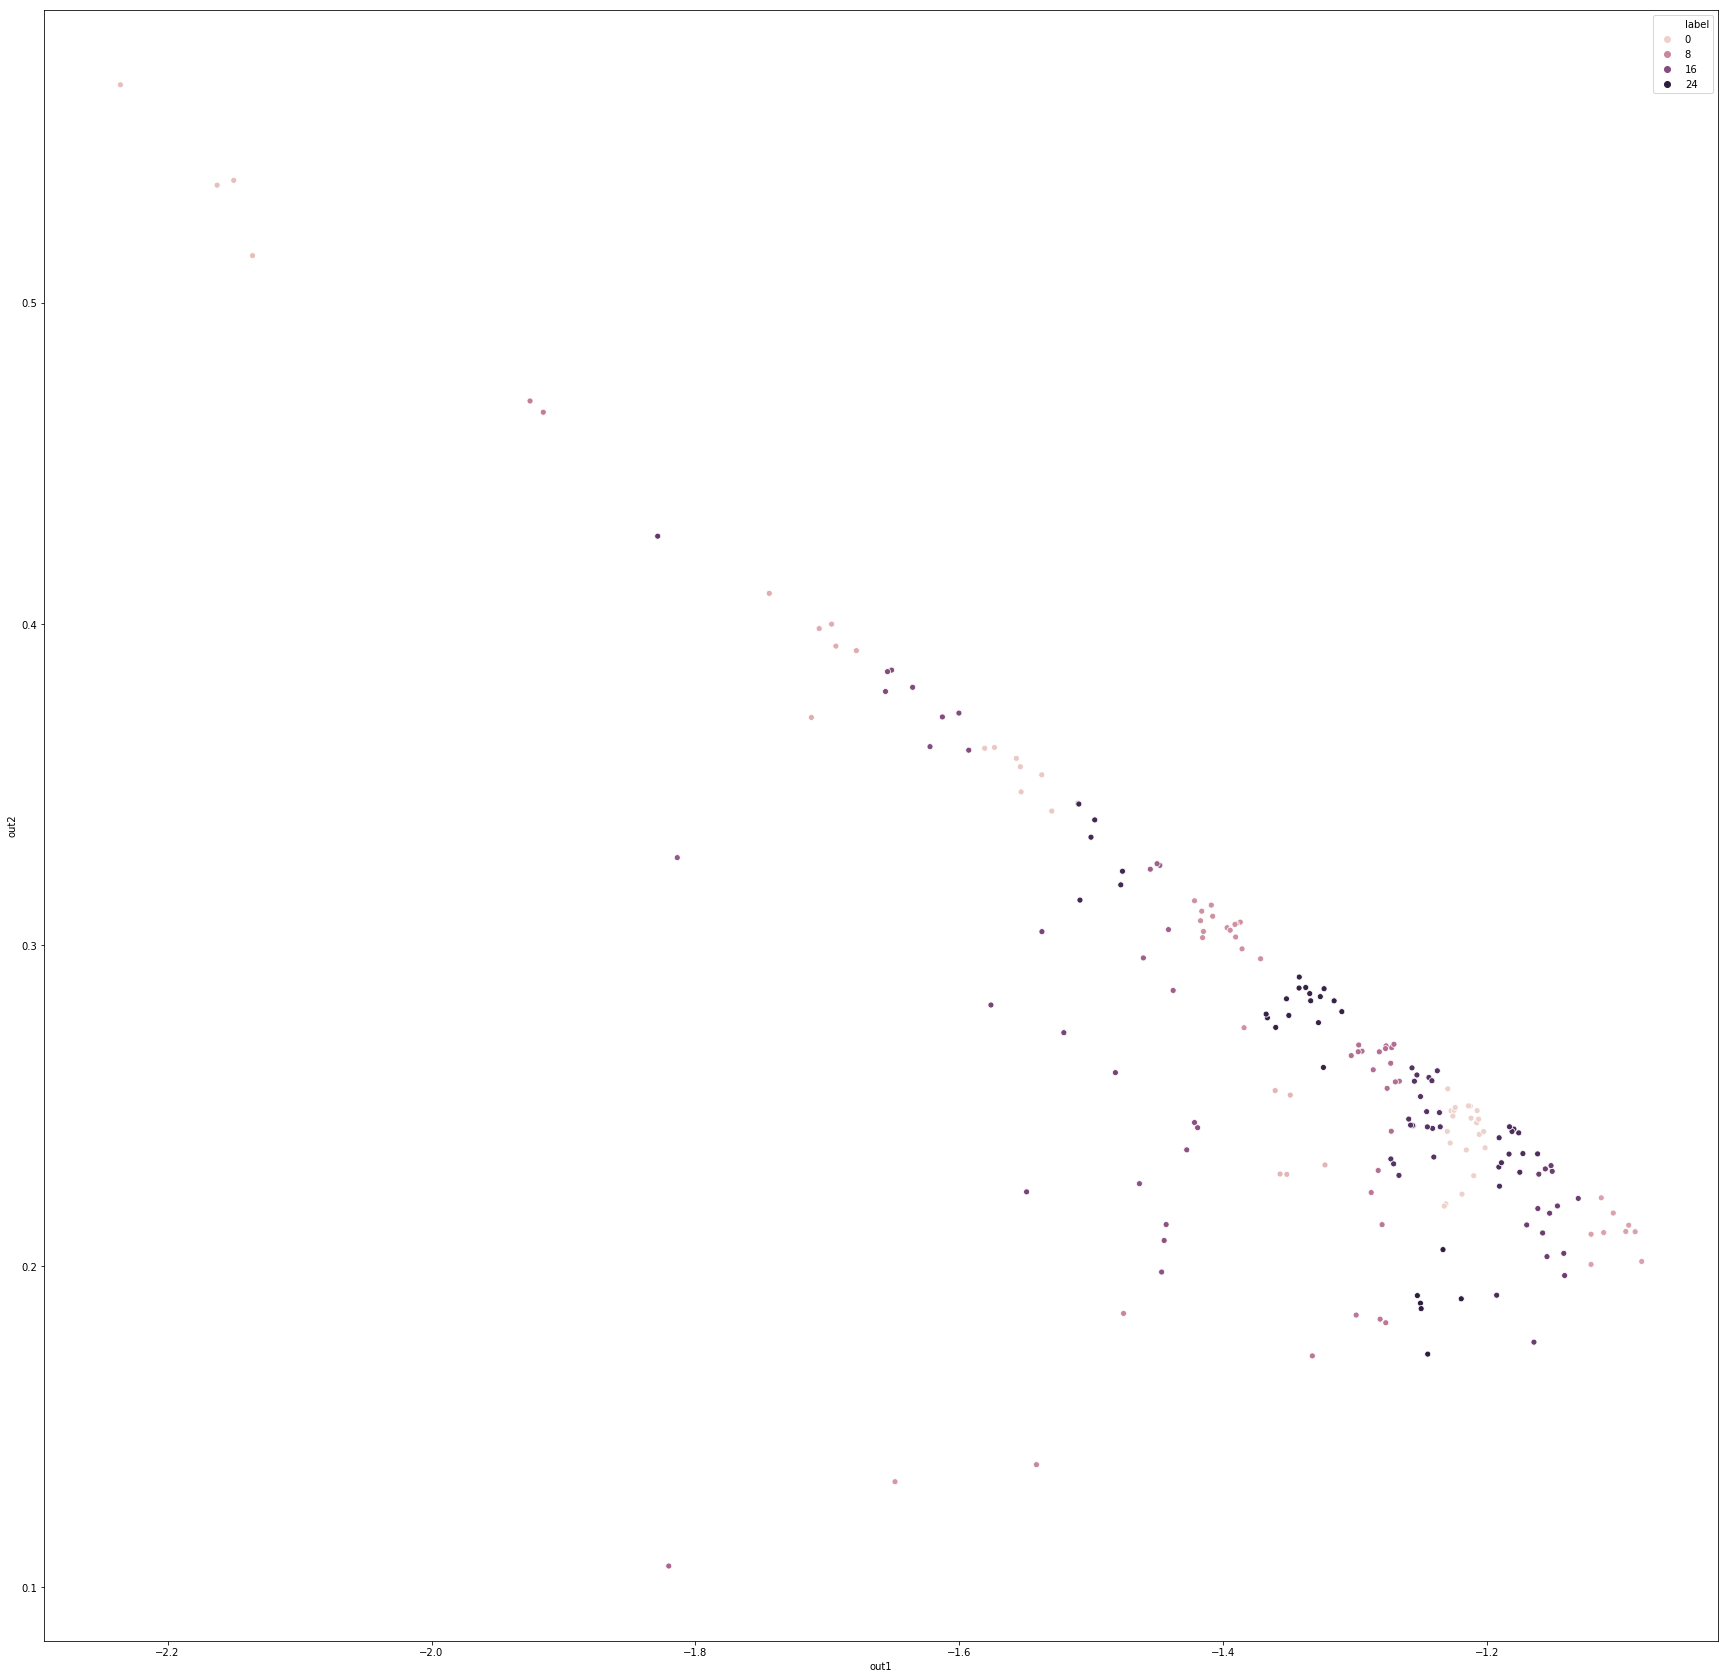

In [79]:
plt.figure(figsize=(30,30))
#plt.subplot(1,3,1)
sns.scatterplot(data=df, x='out1', y='out2', hue='label')

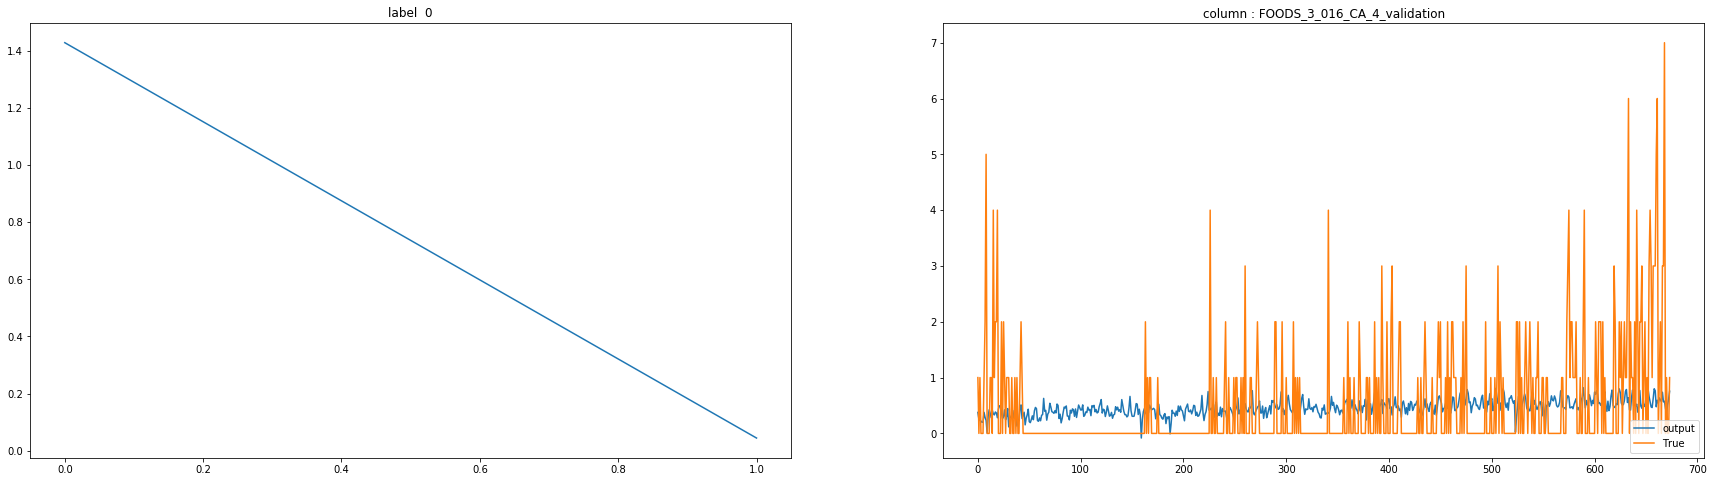

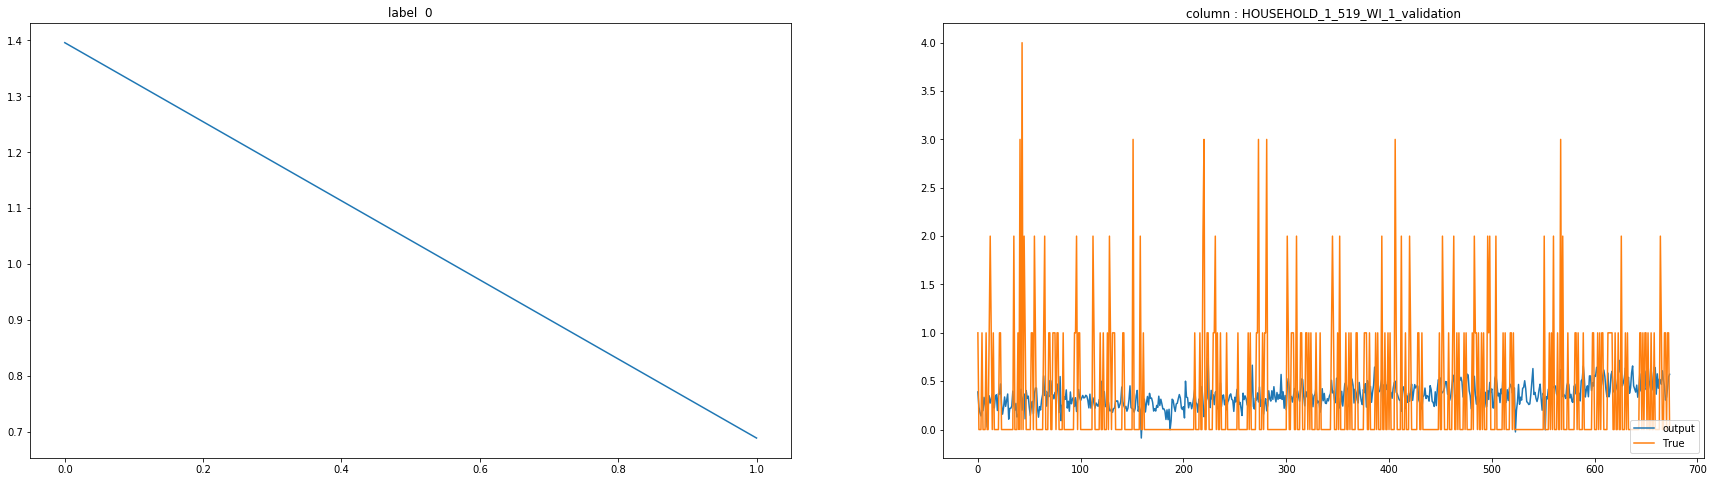

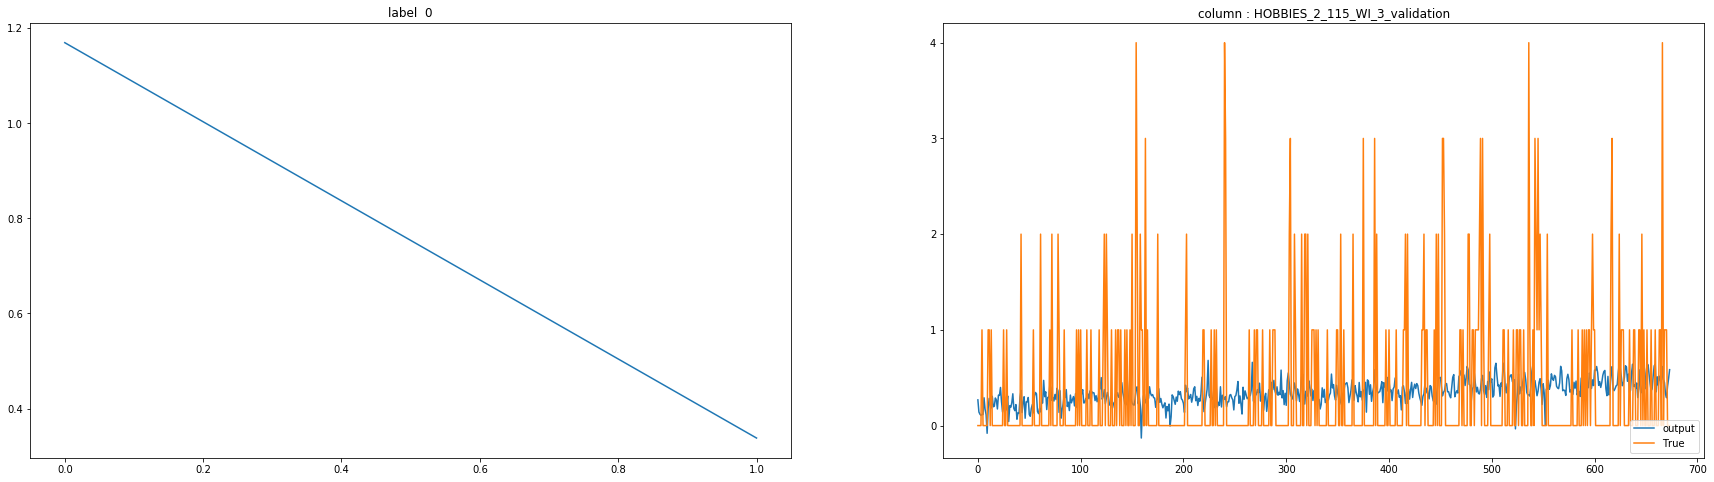

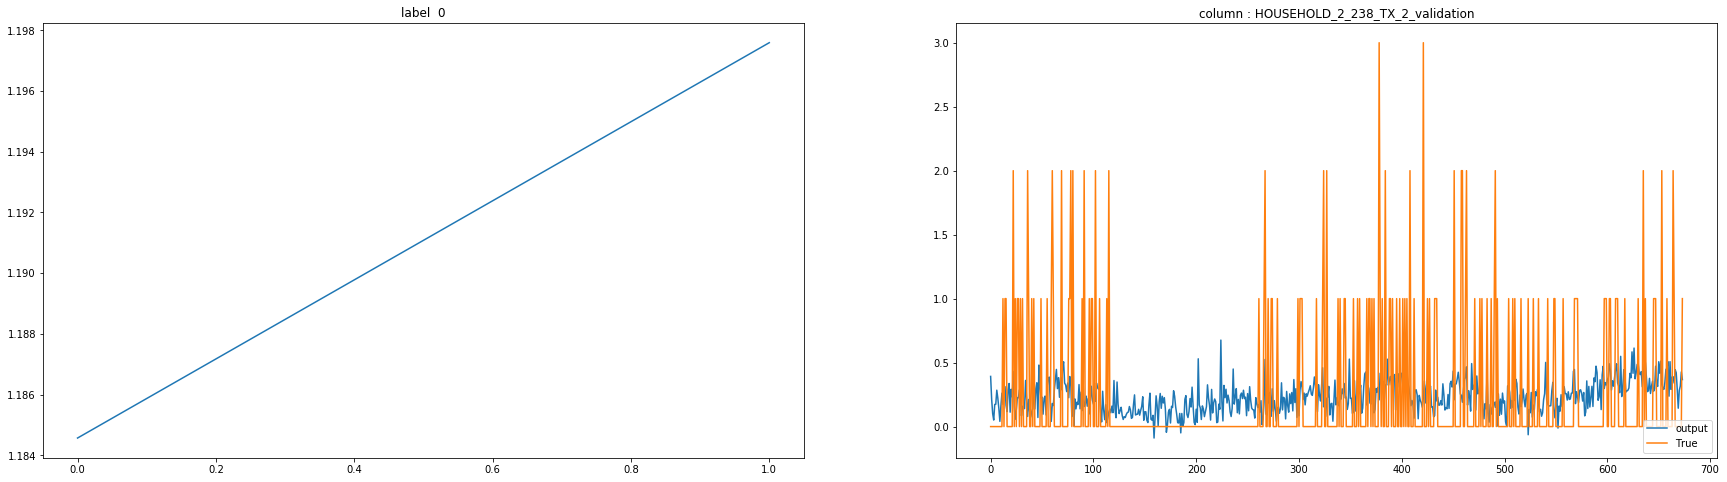

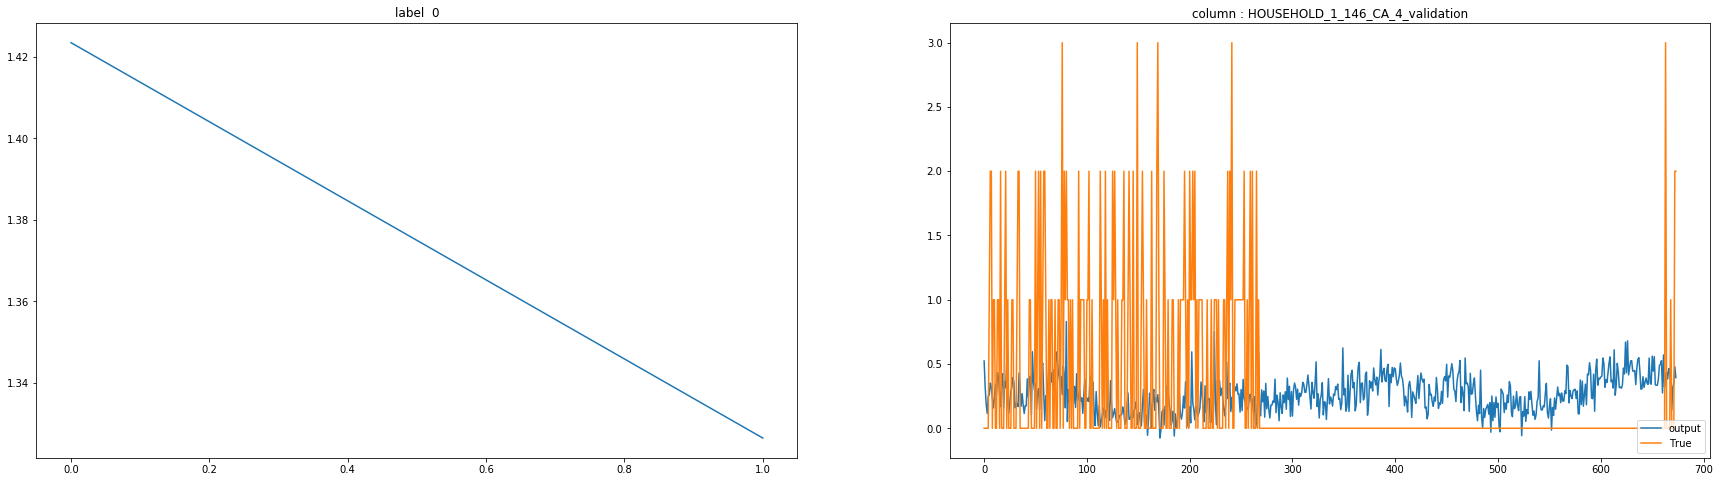

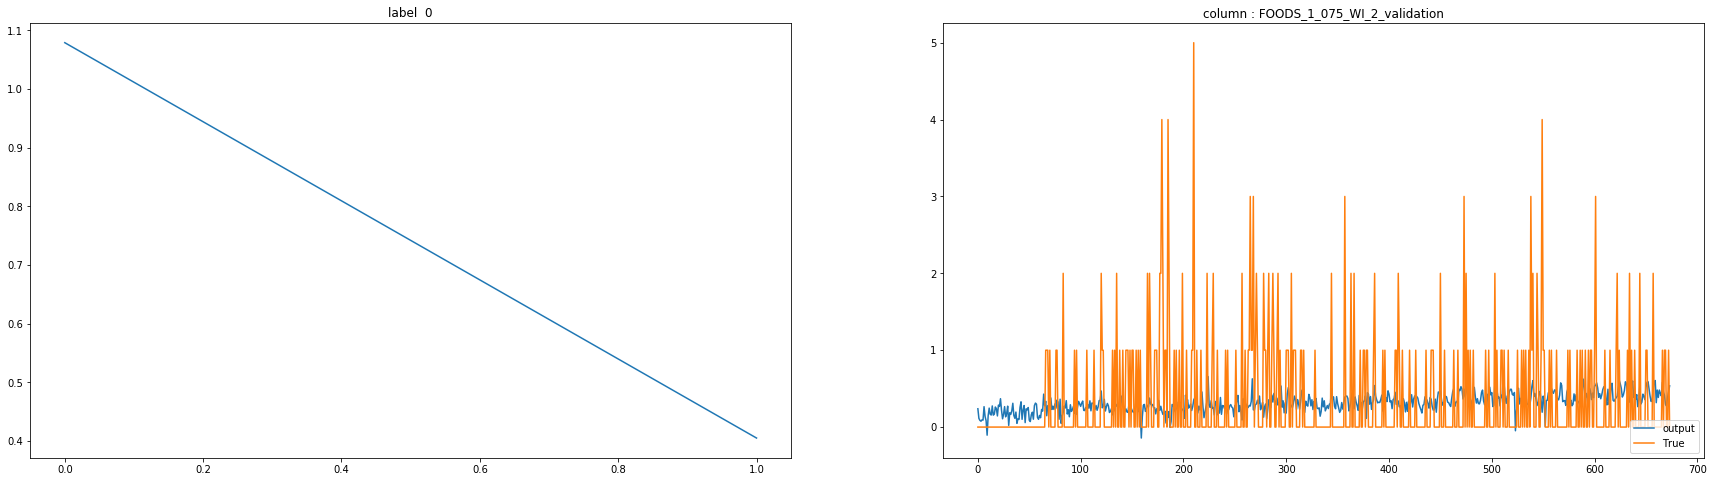

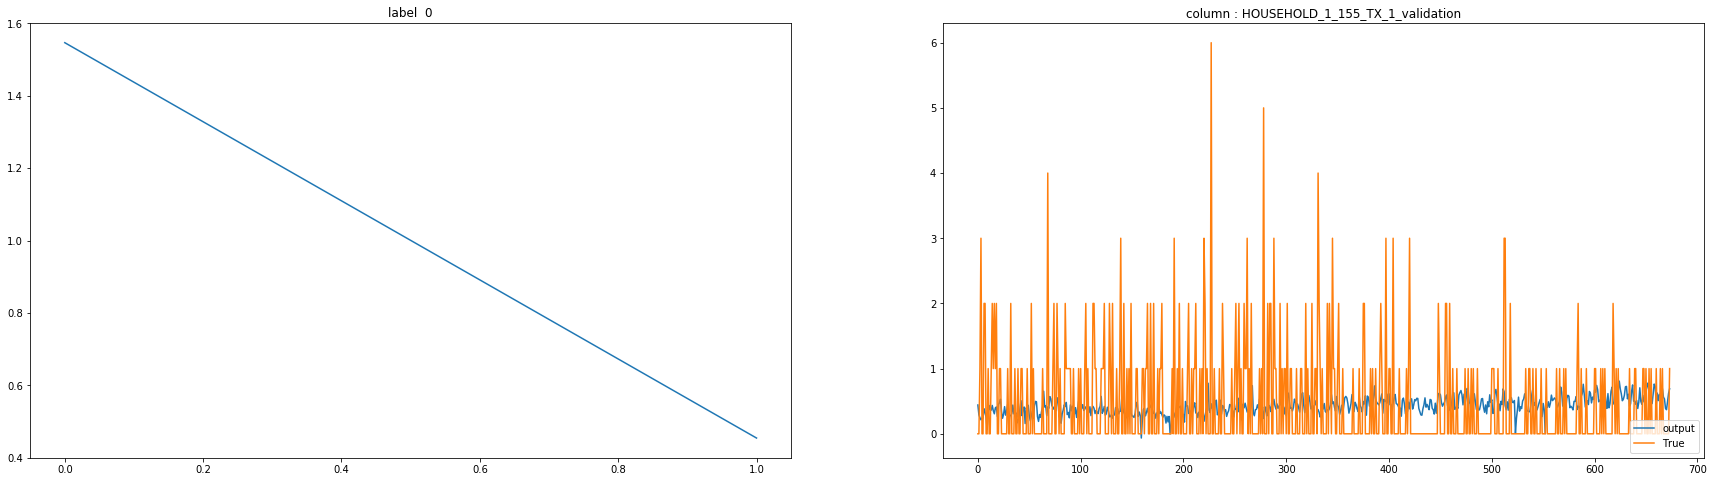

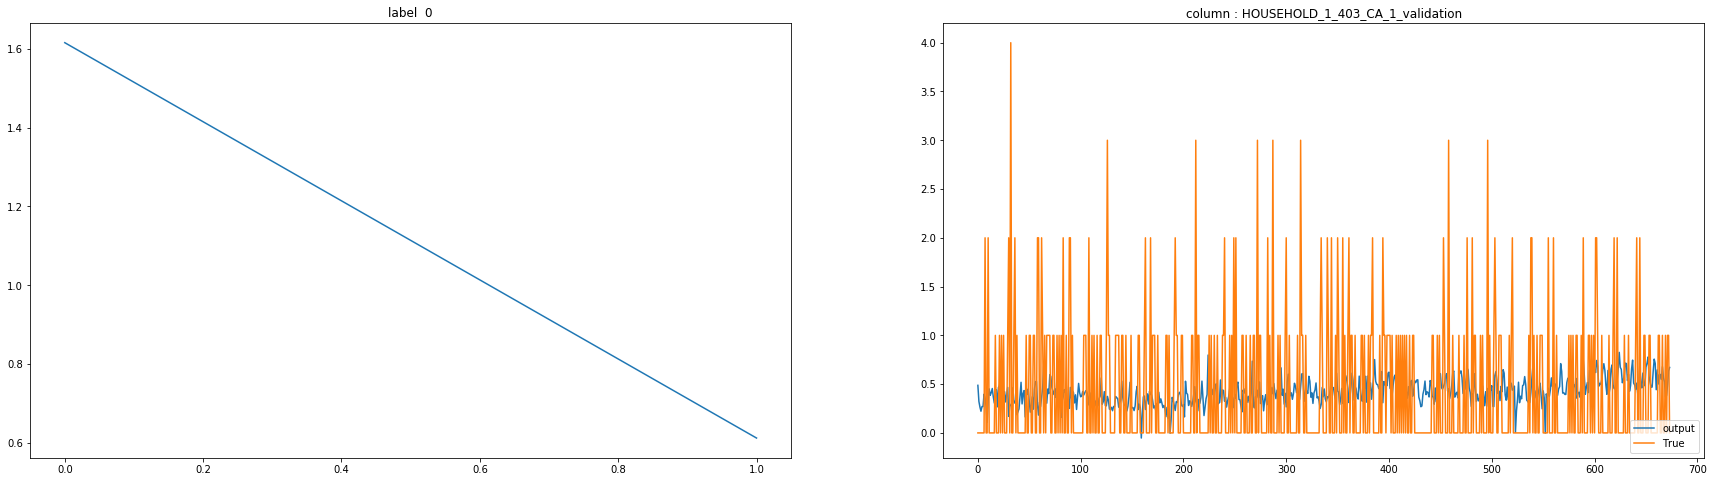

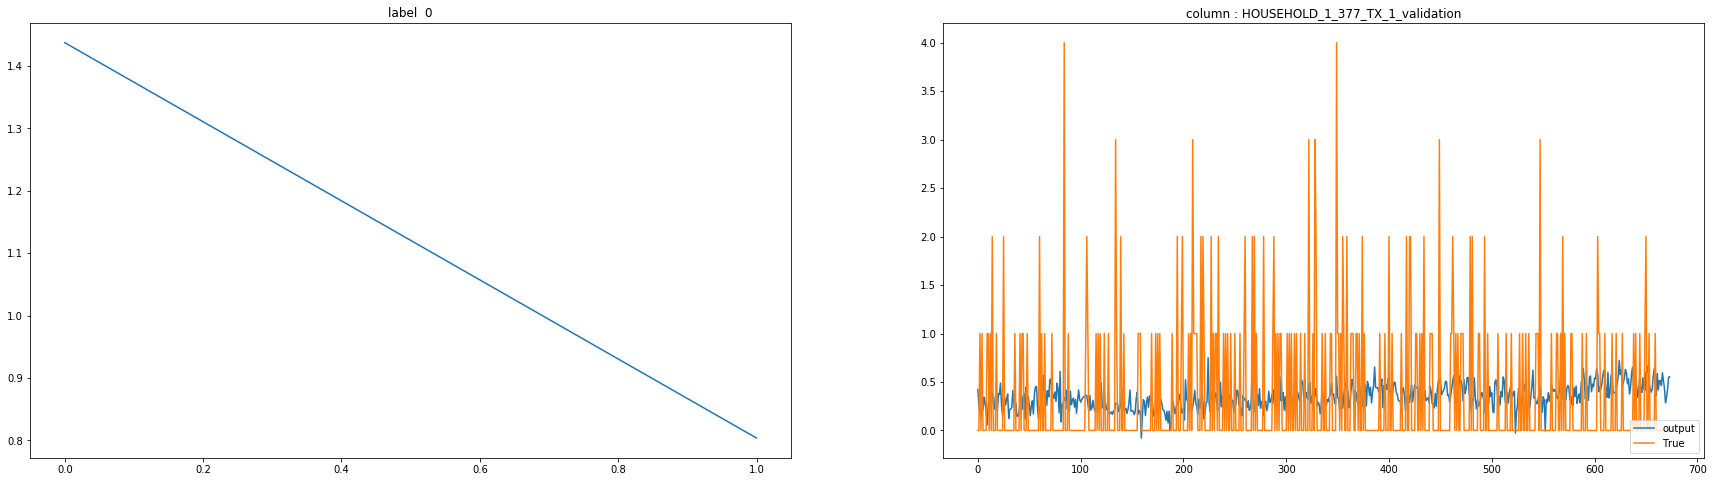

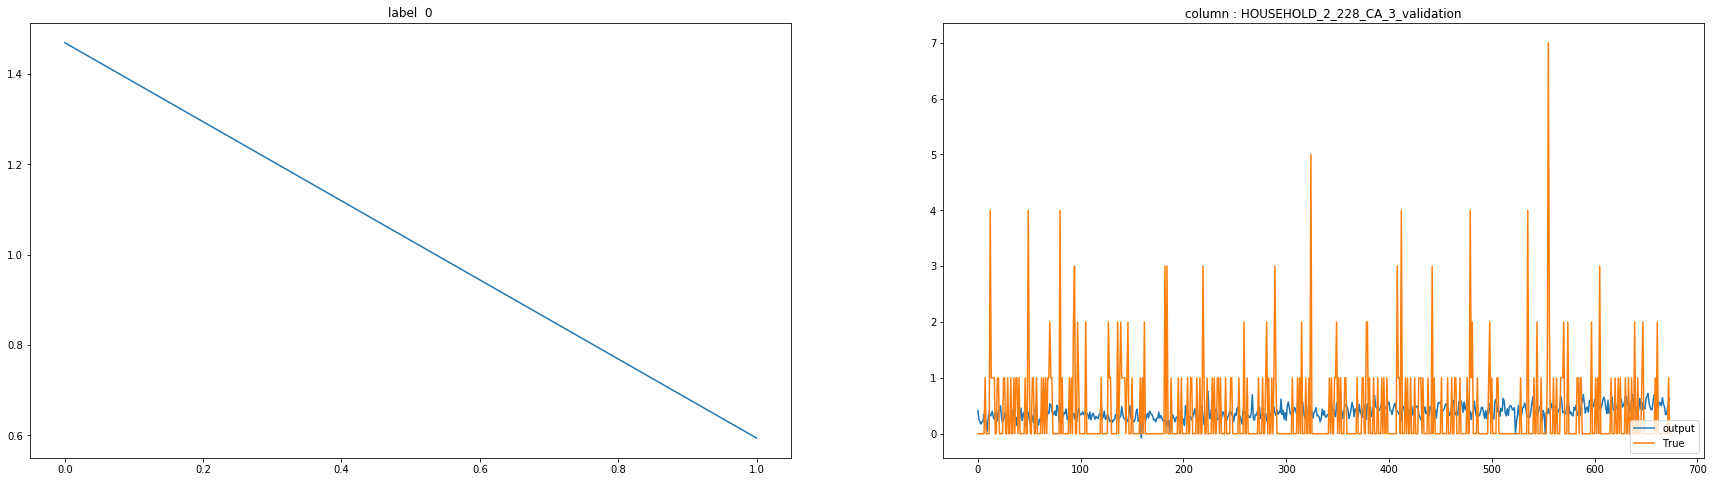

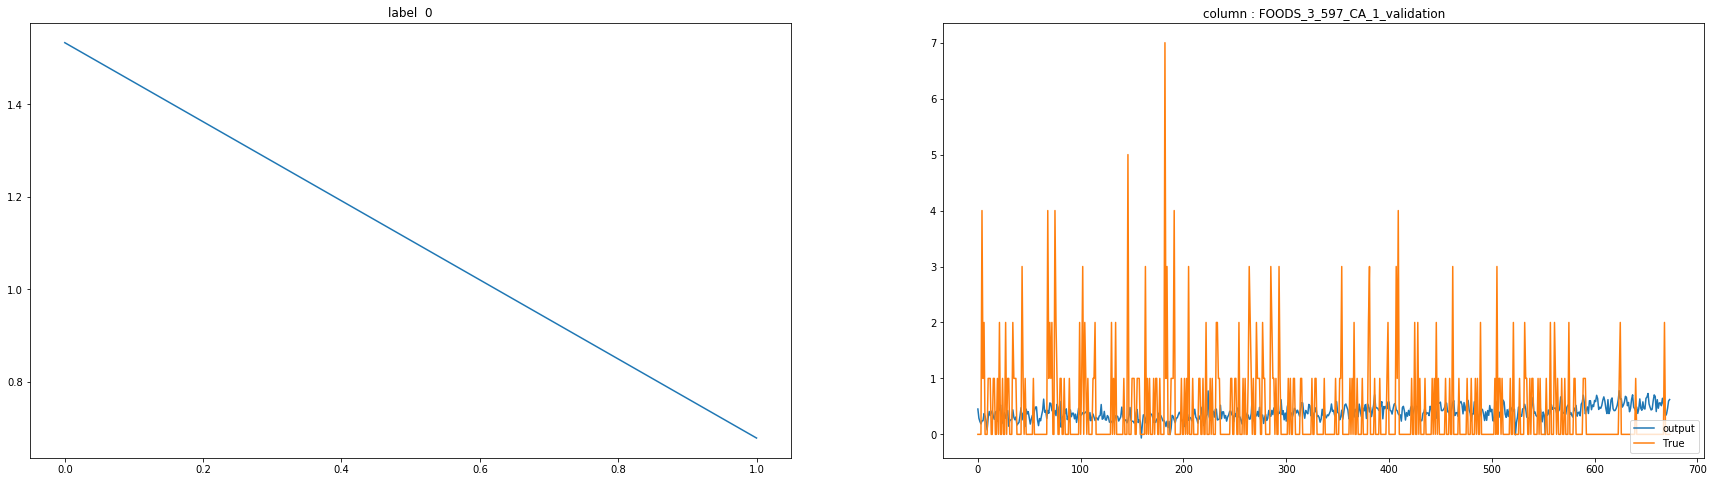

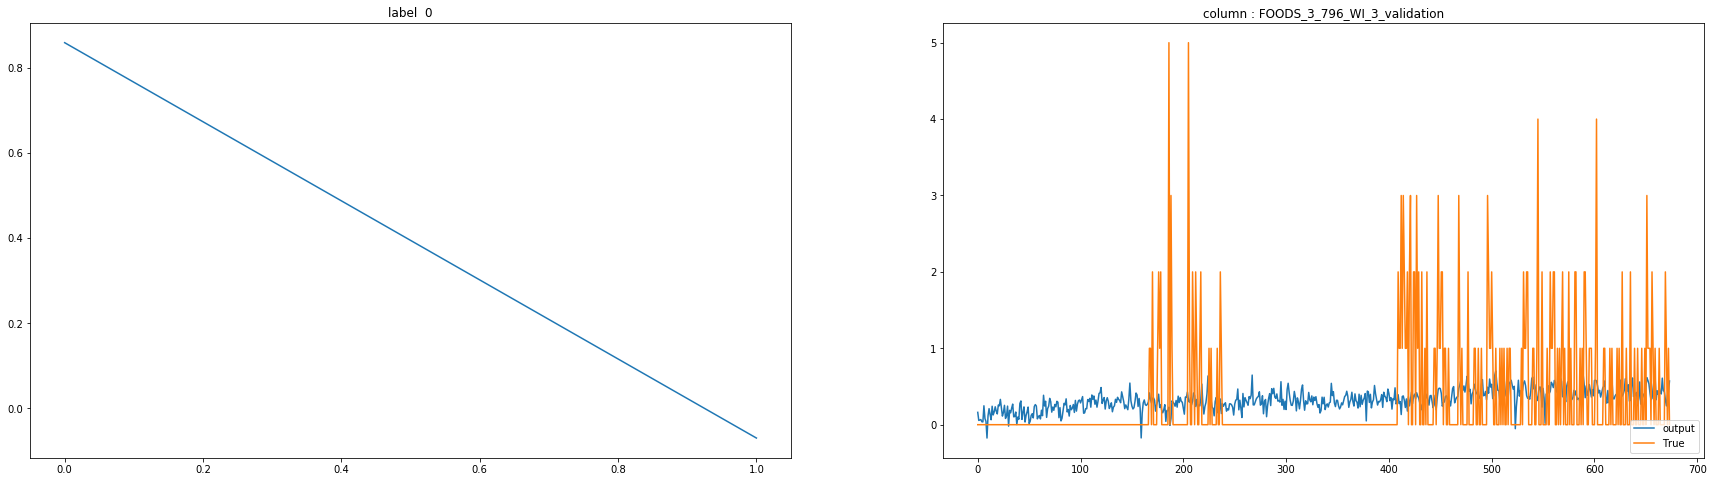

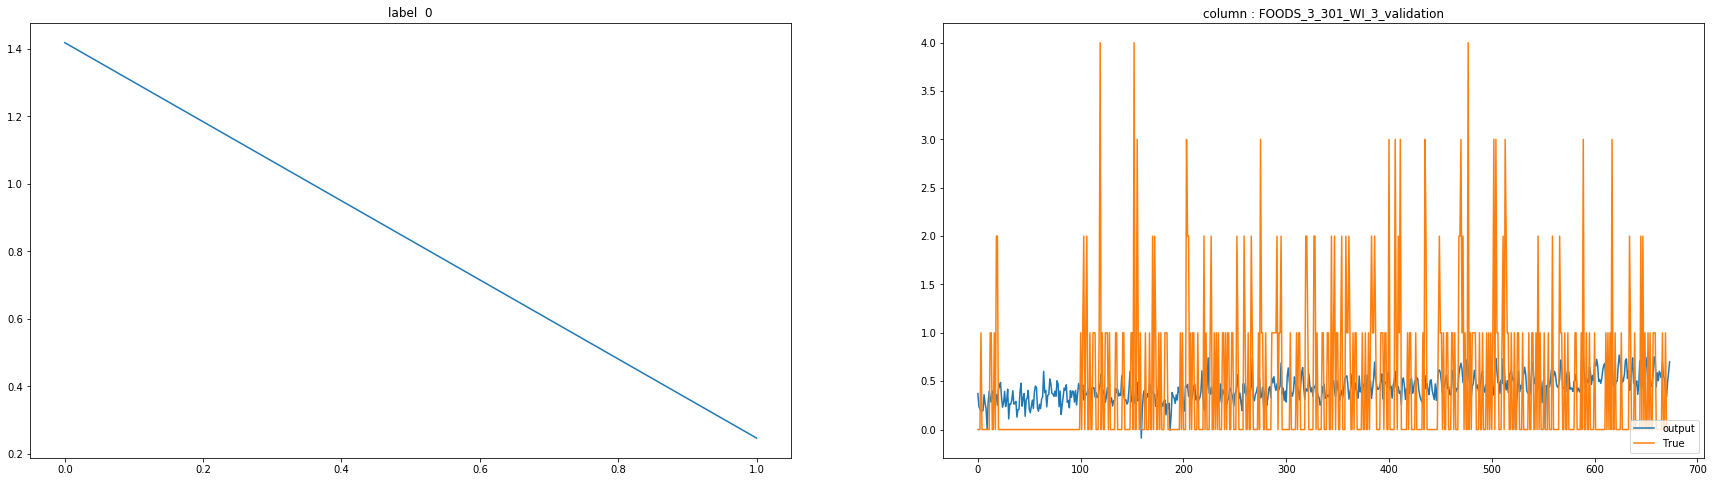

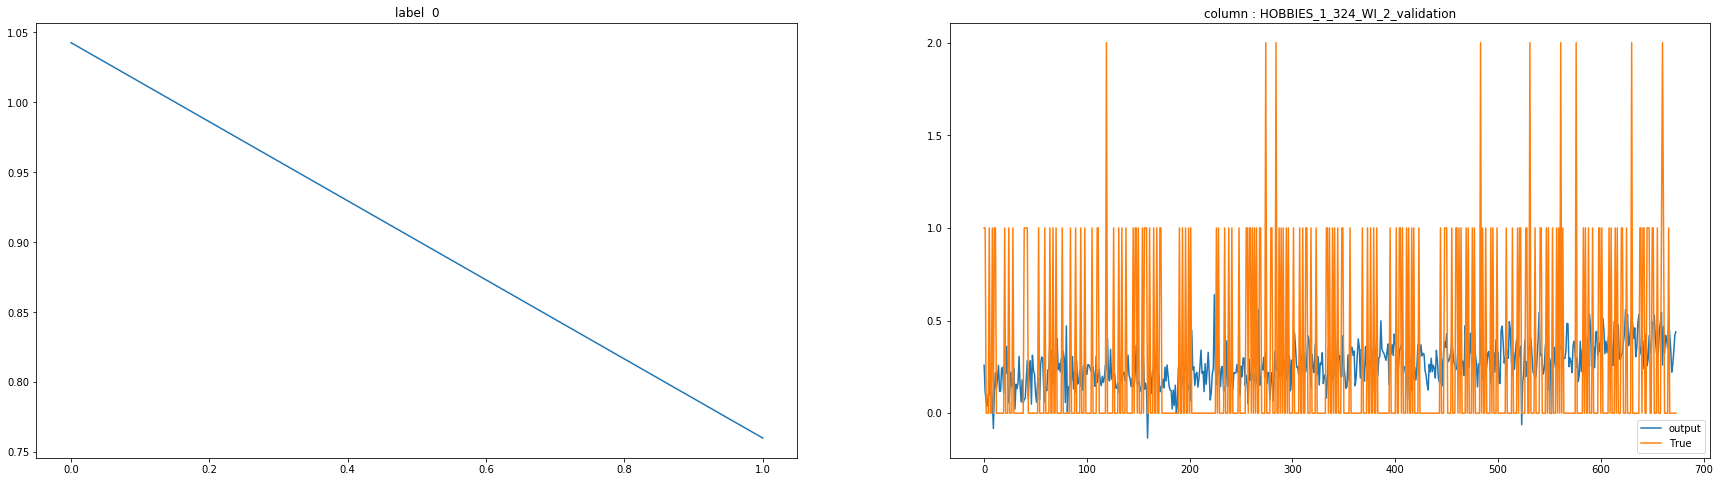

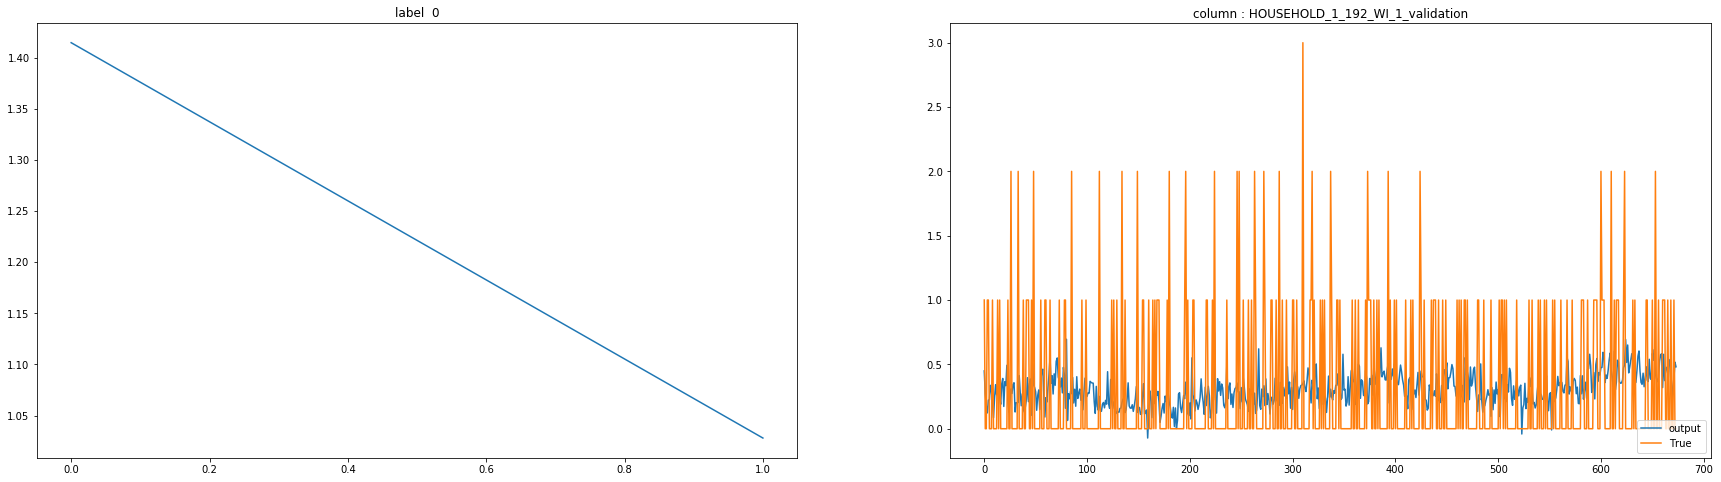

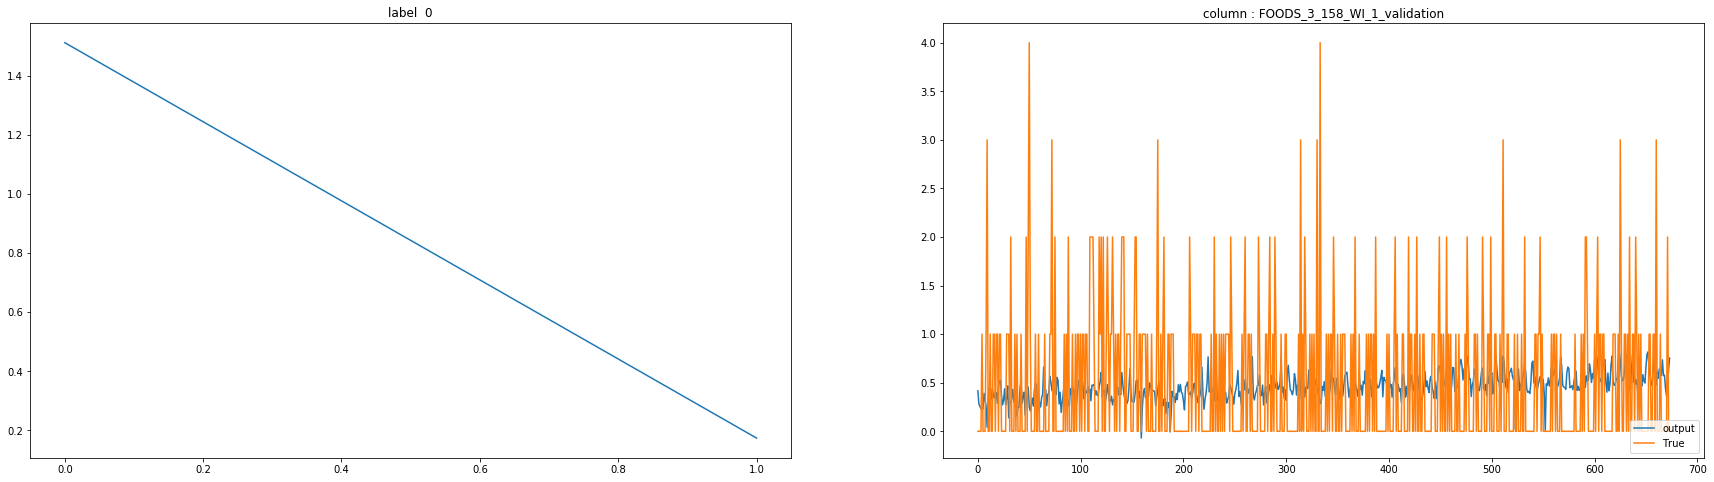

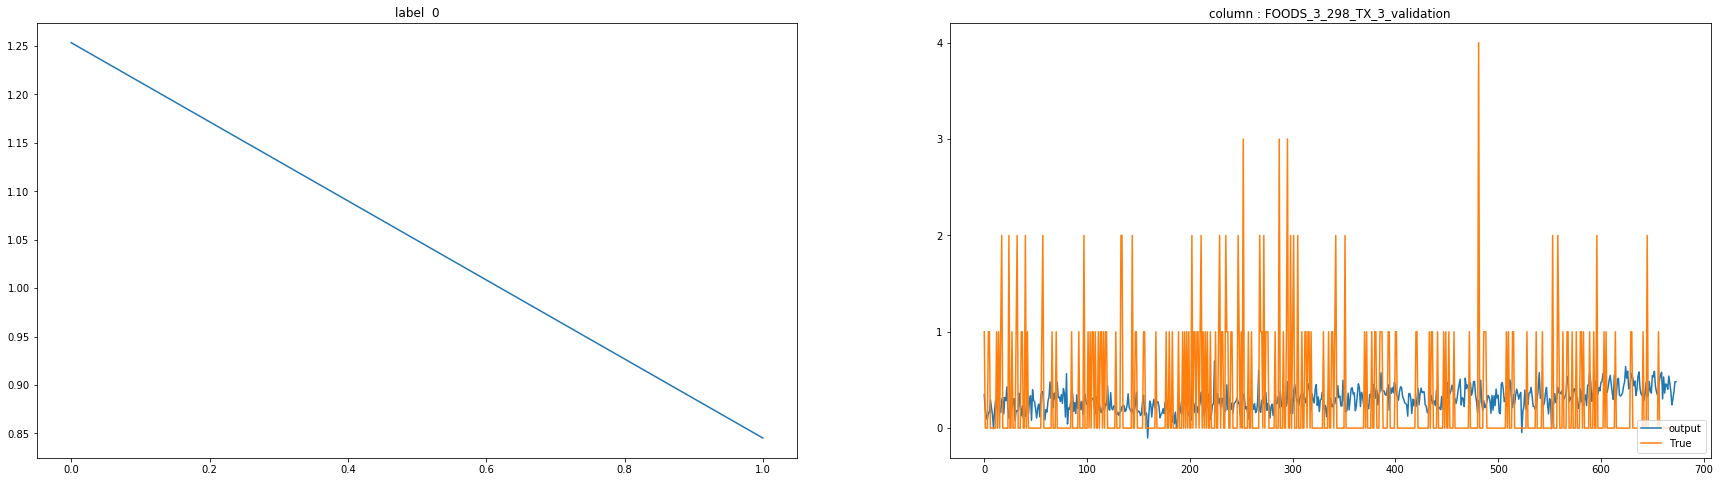

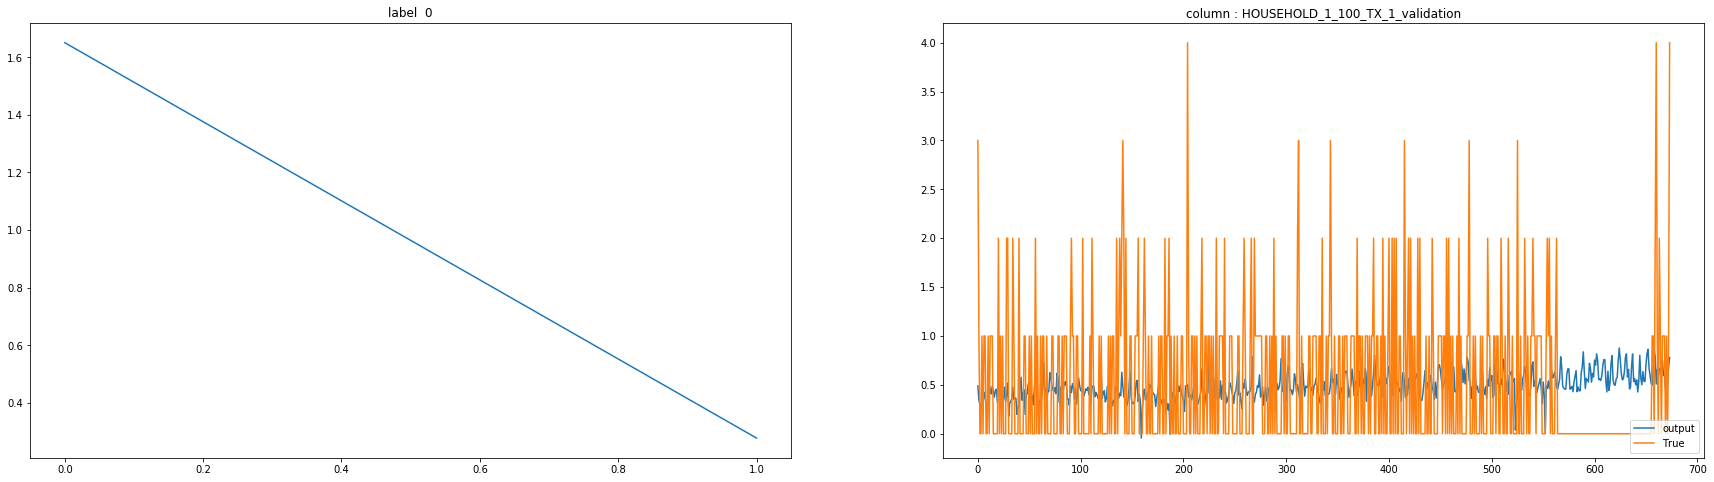

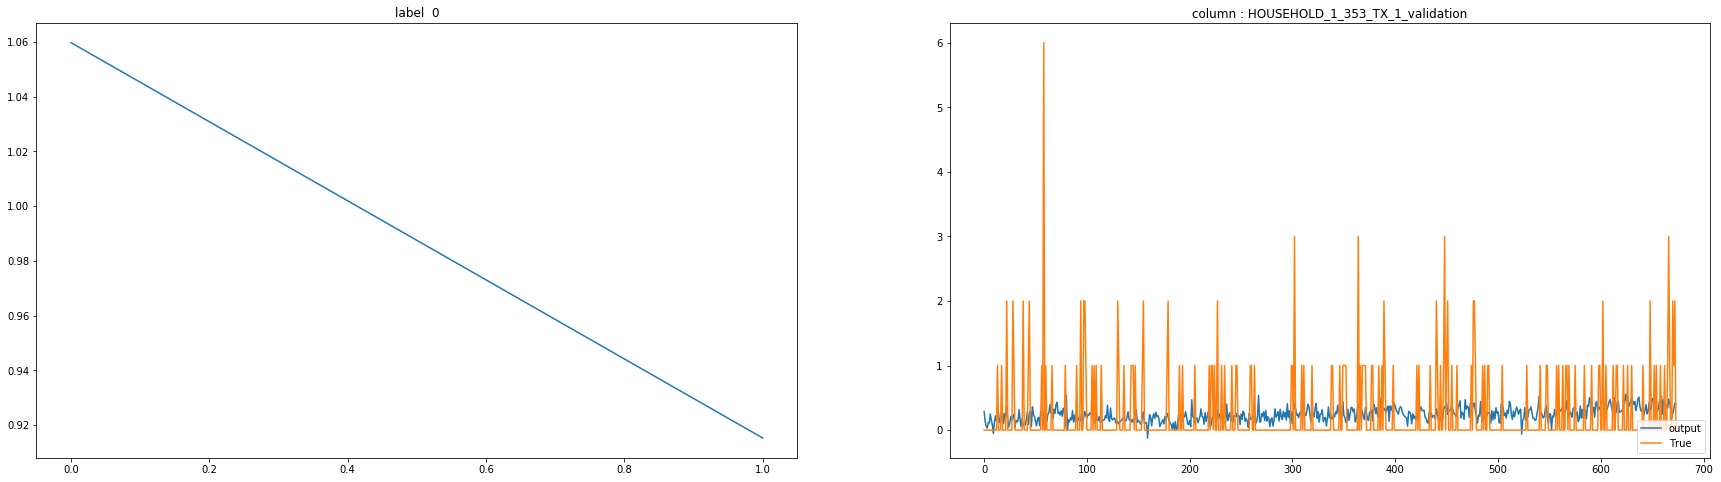

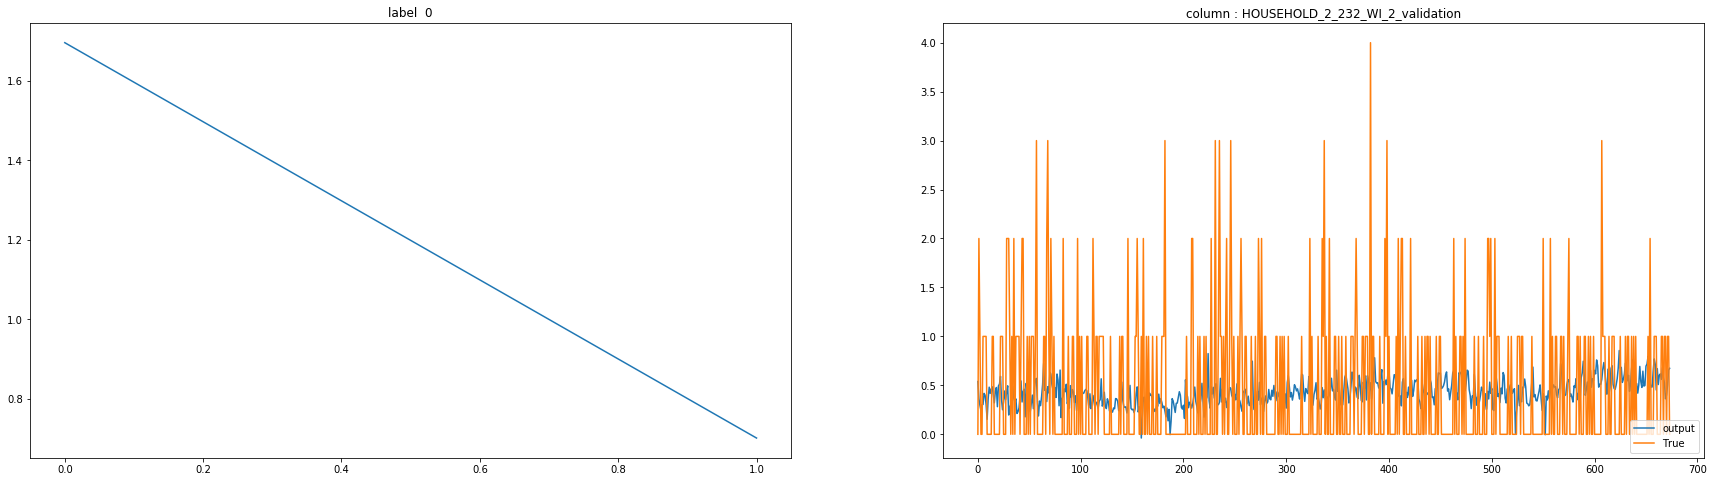

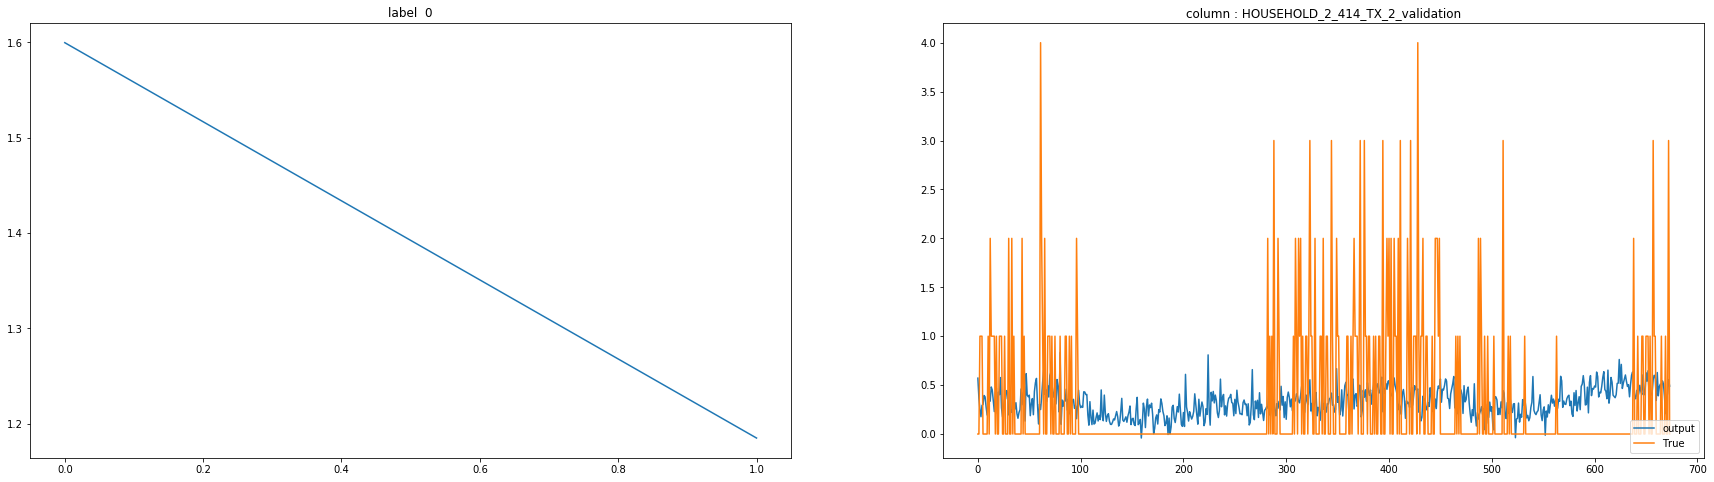

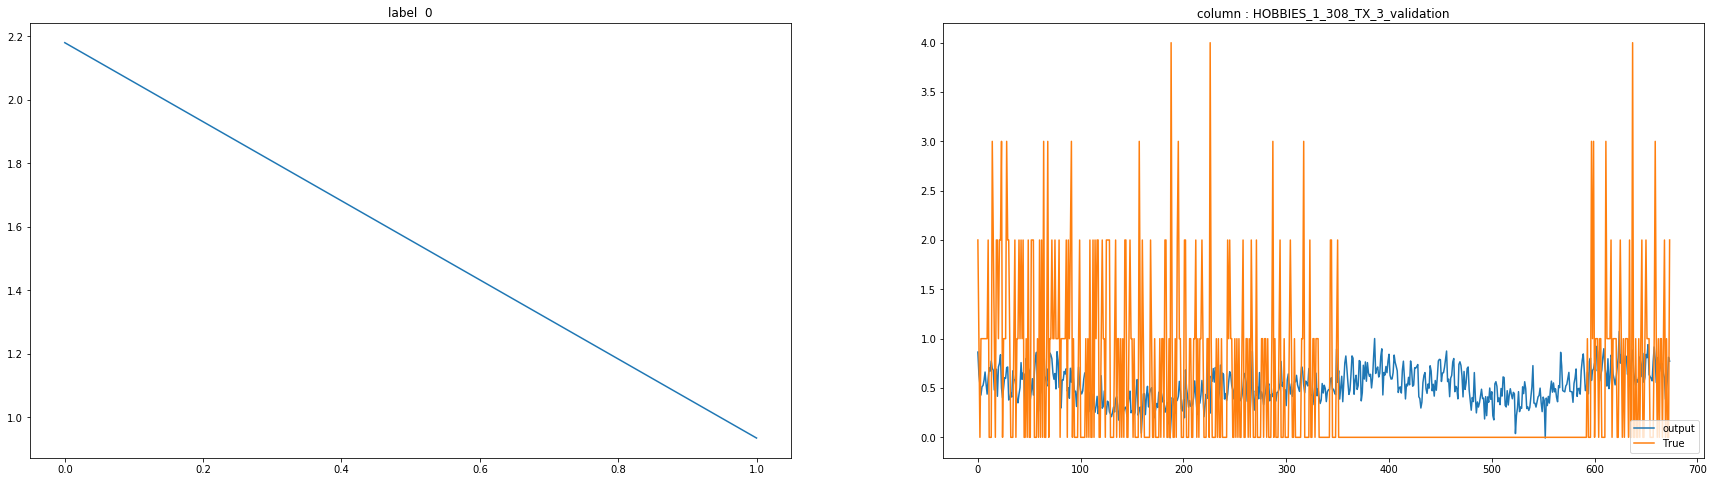

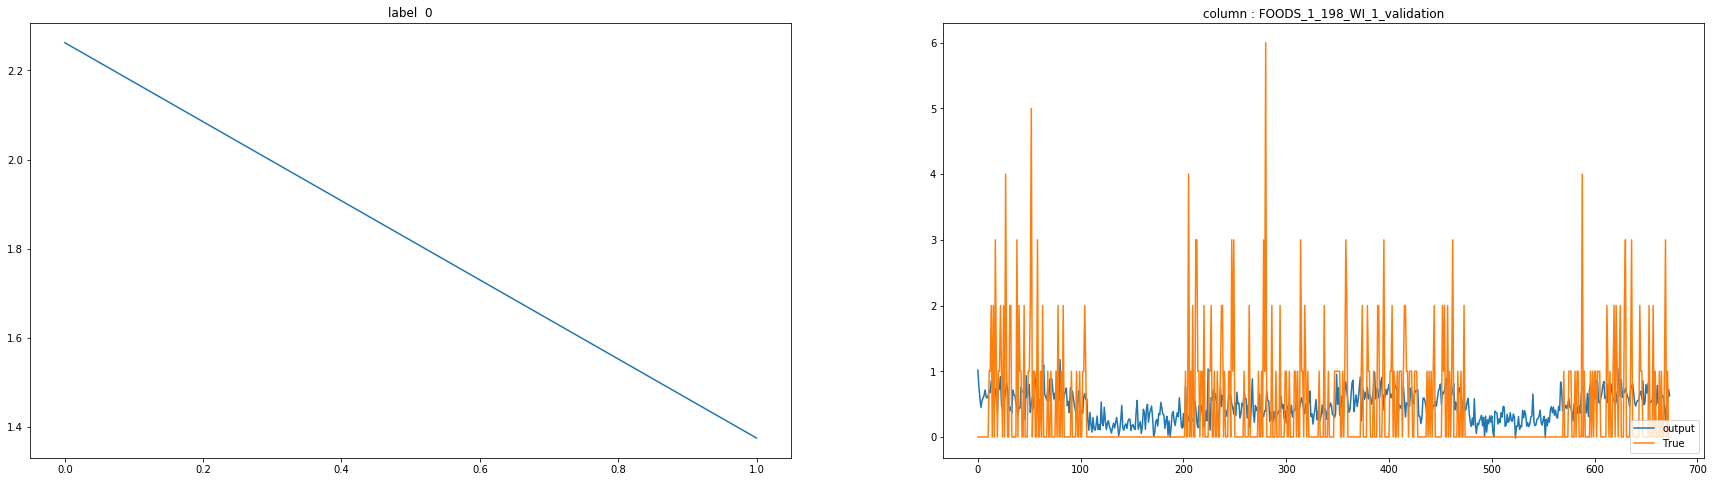

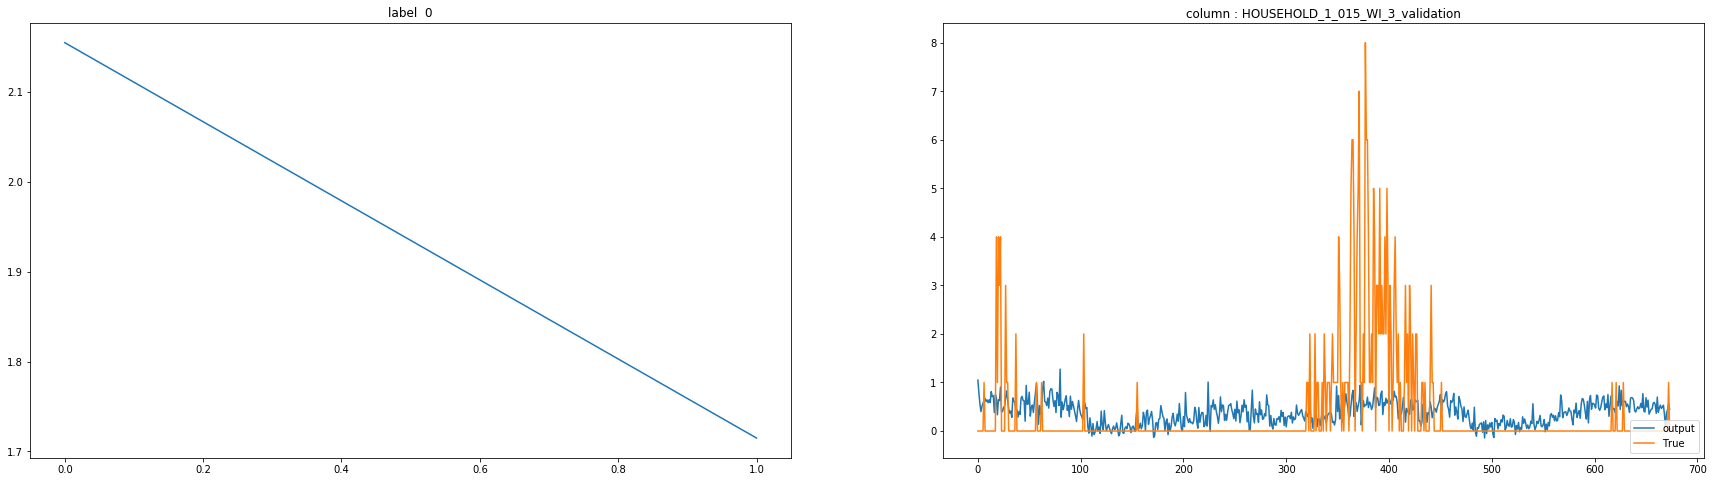

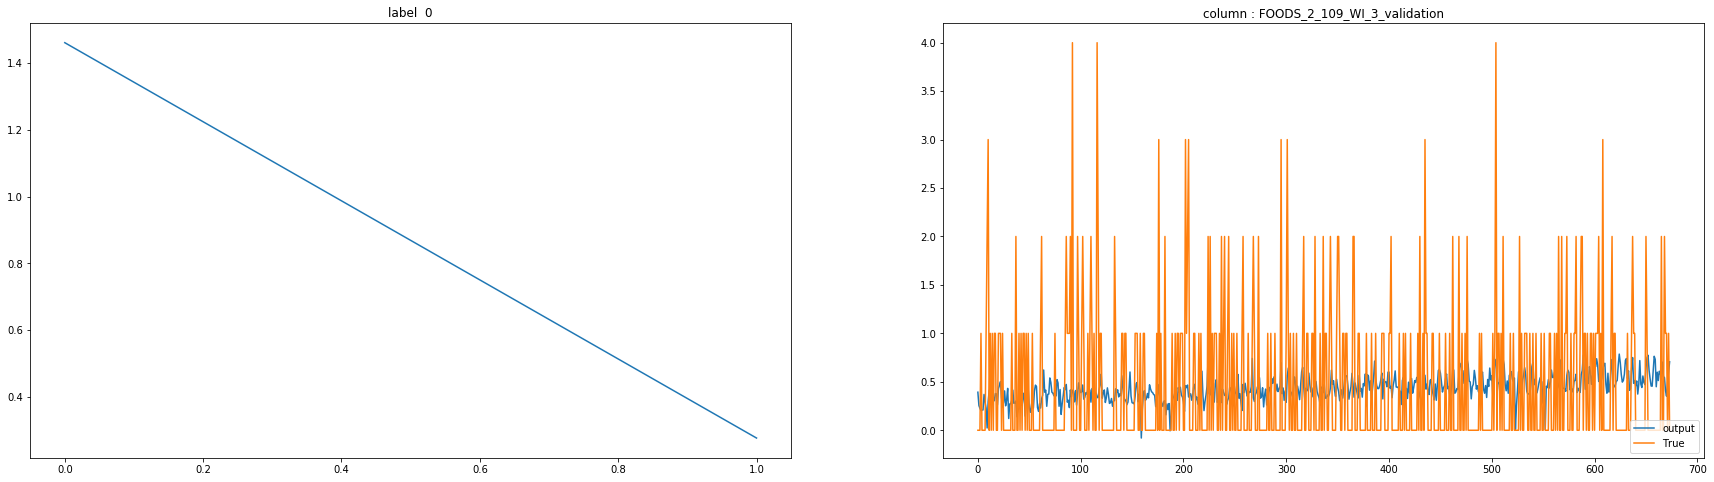

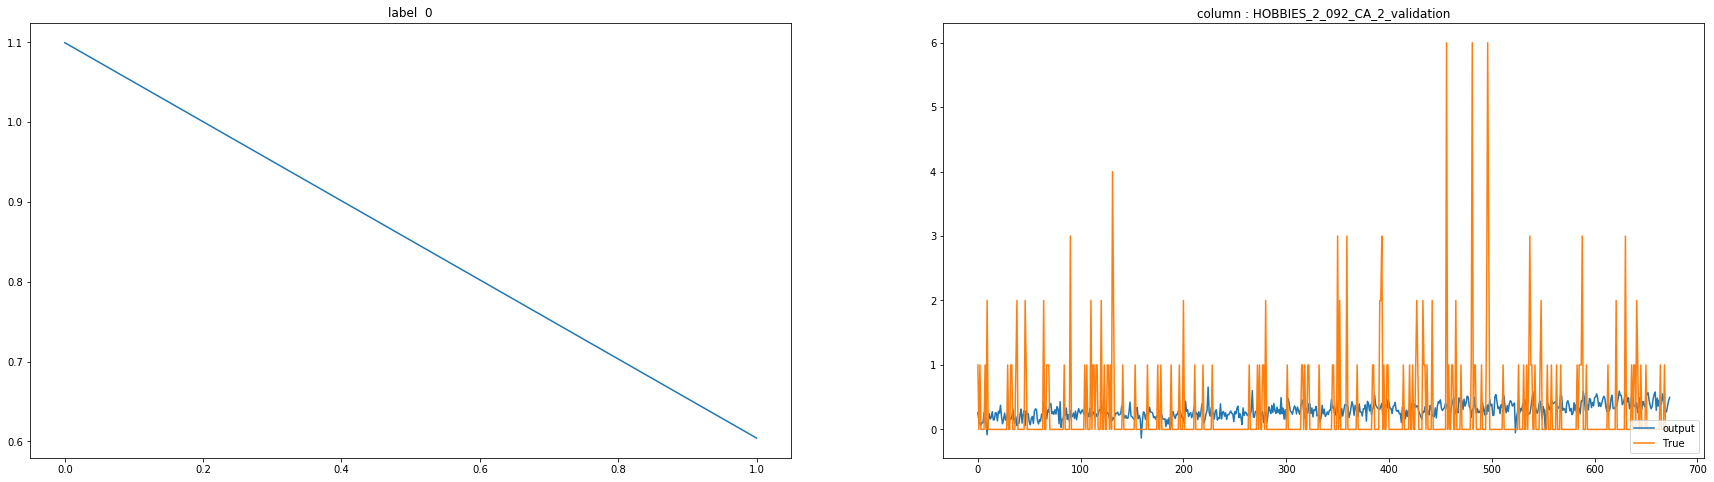

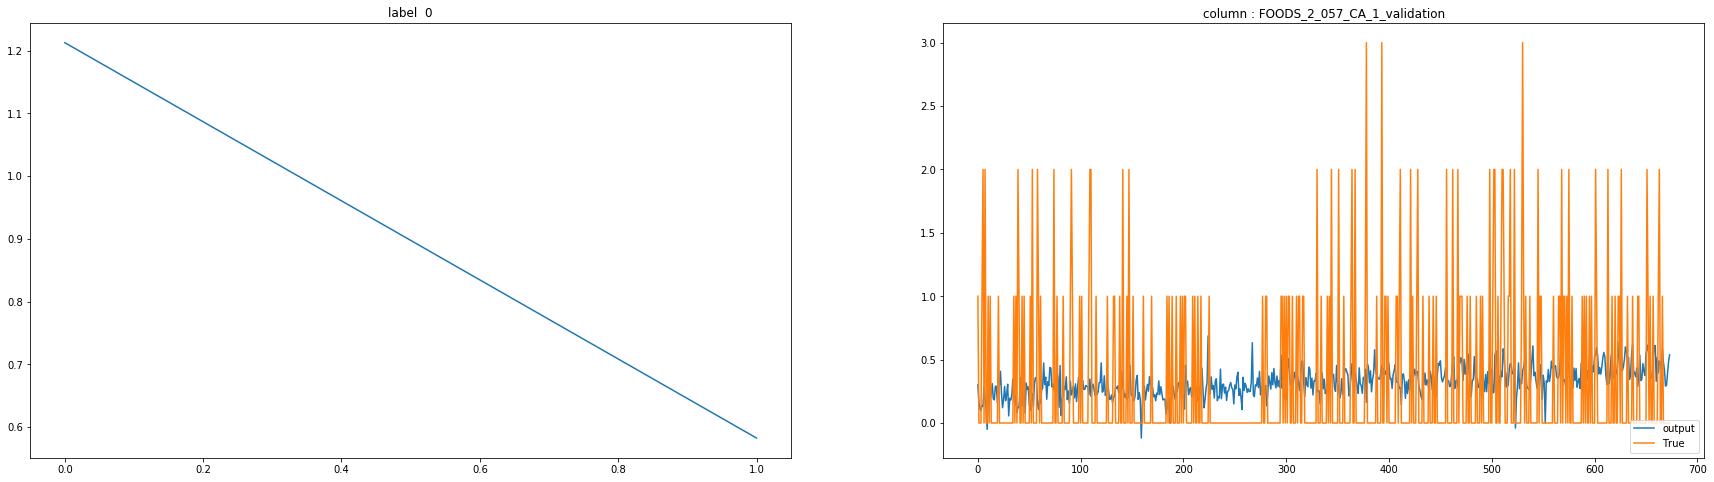

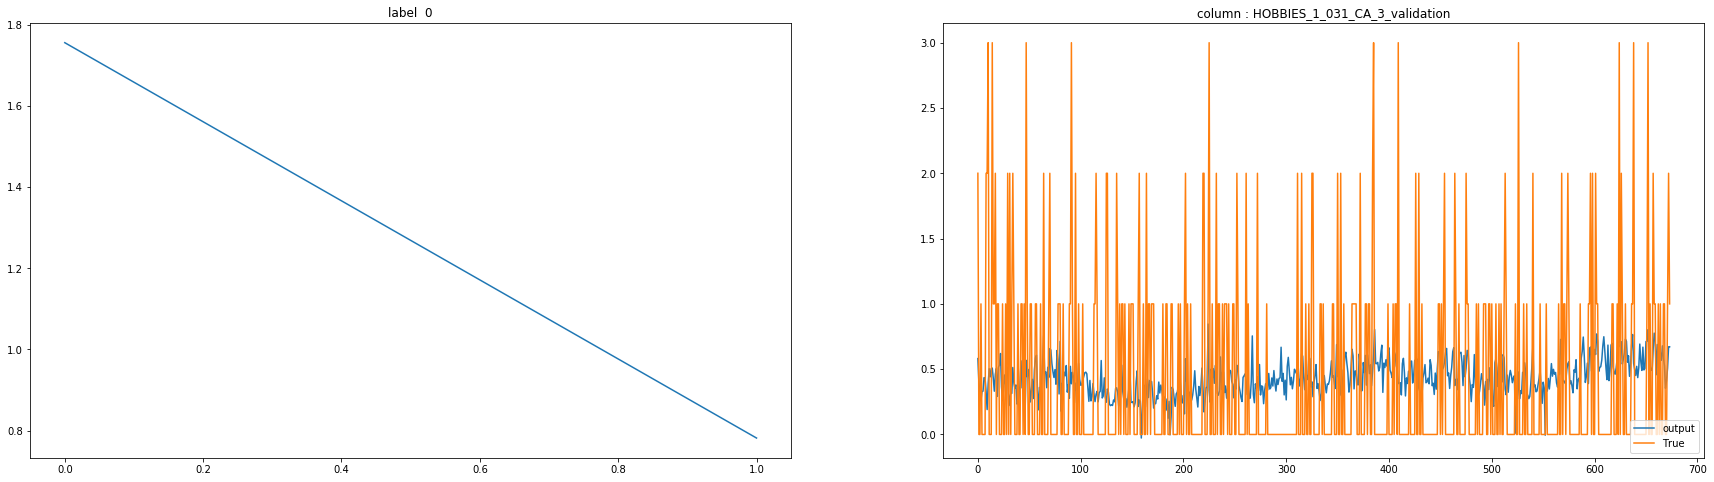

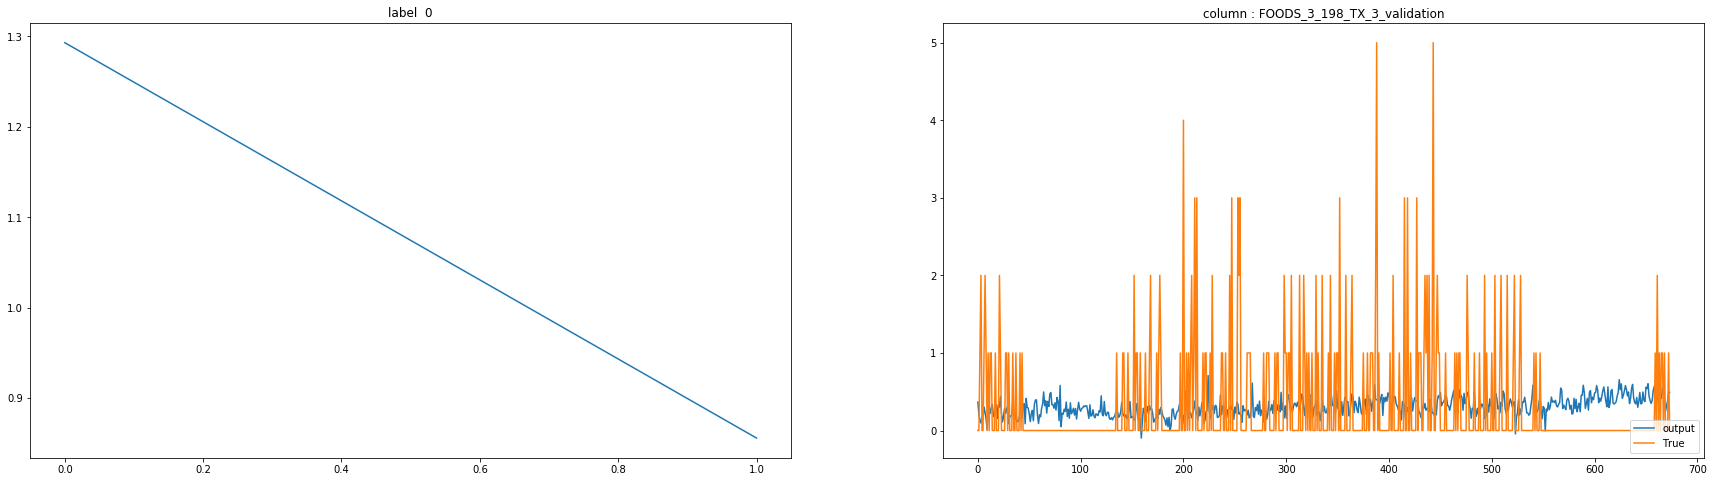

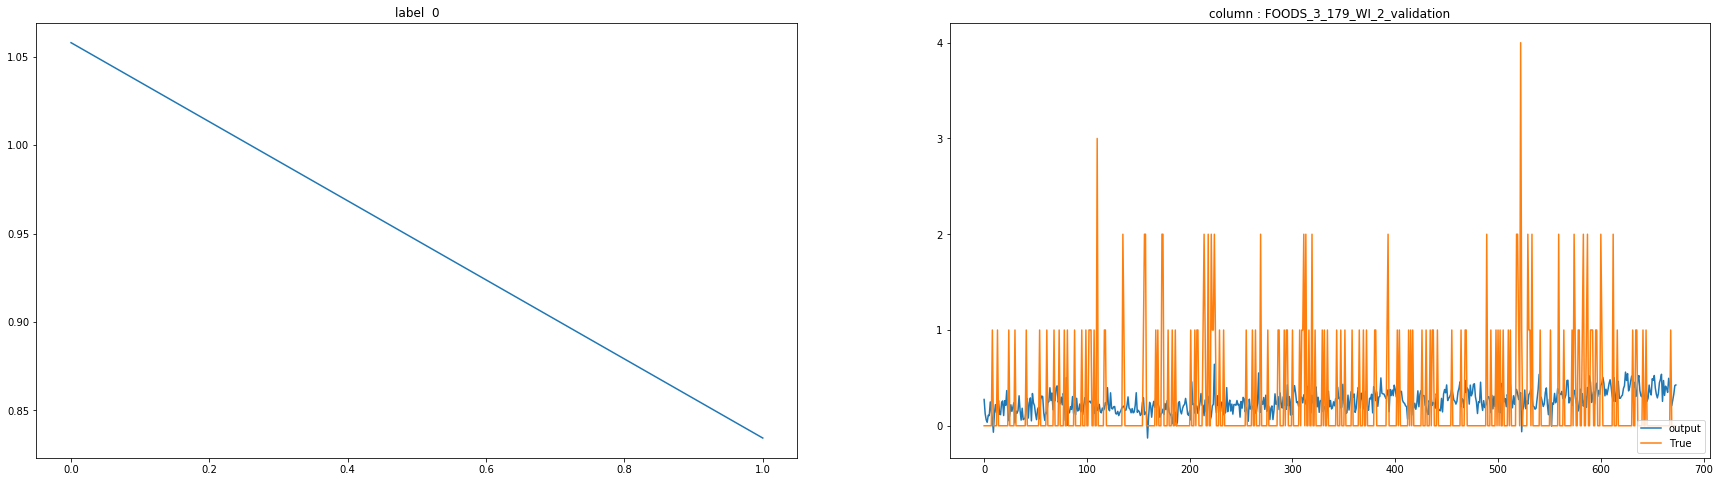

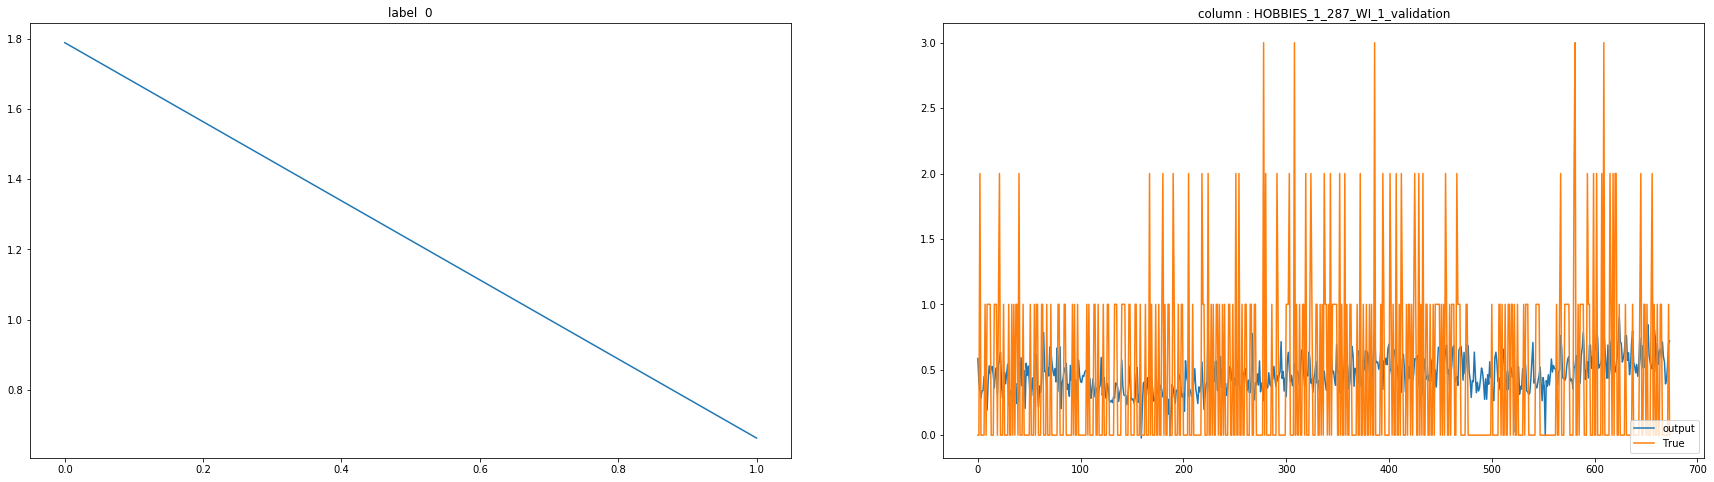

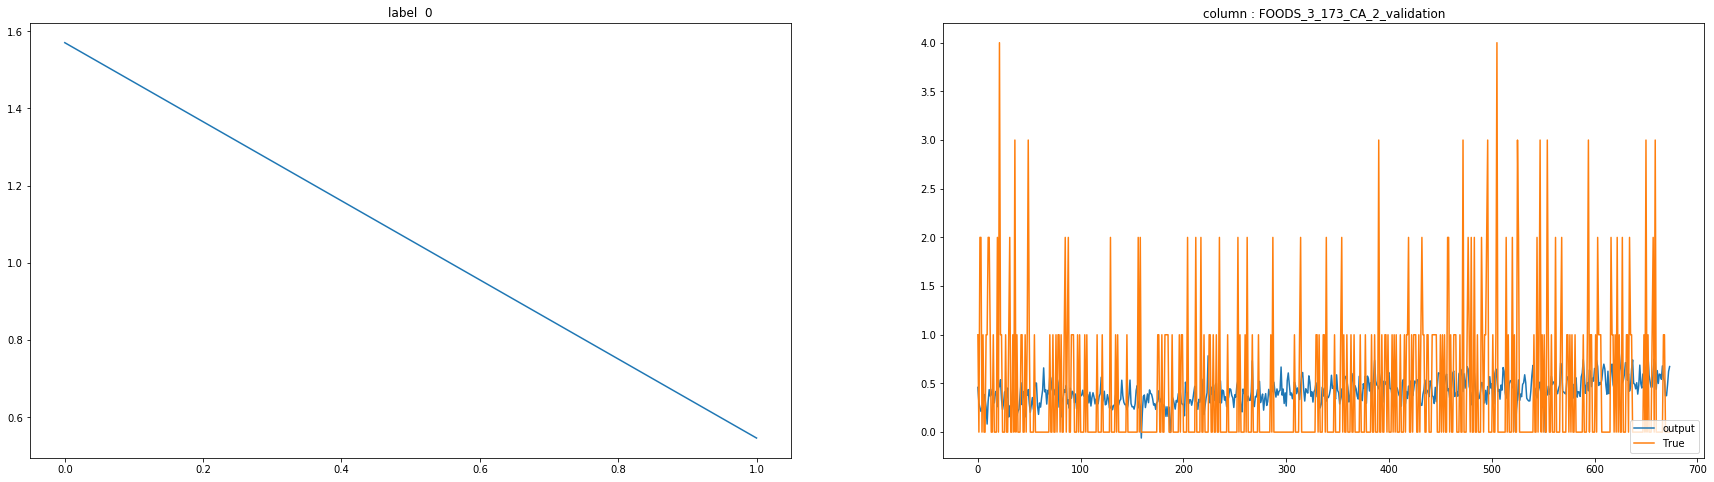

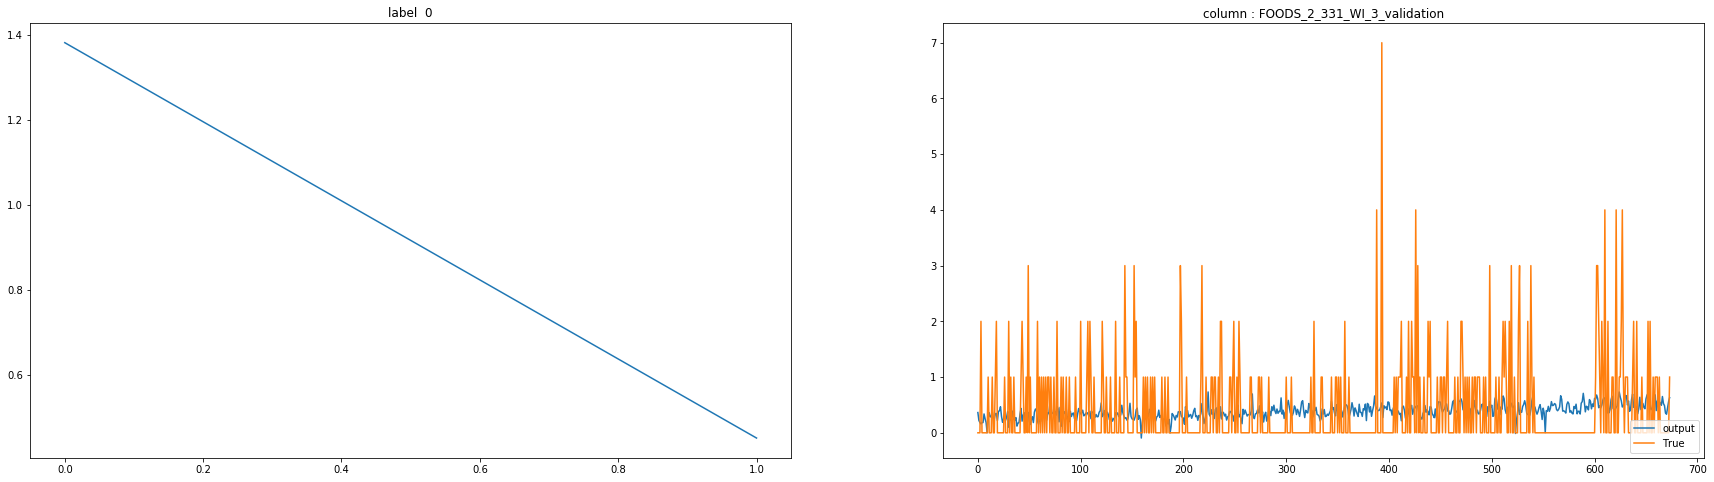

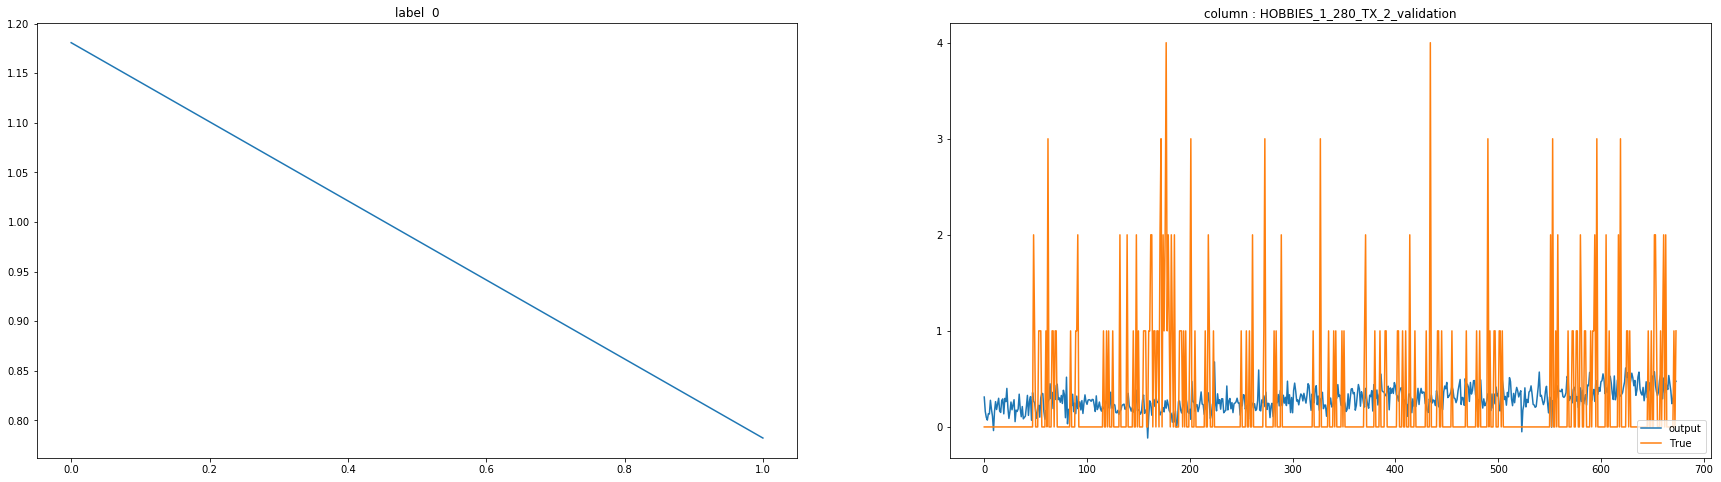

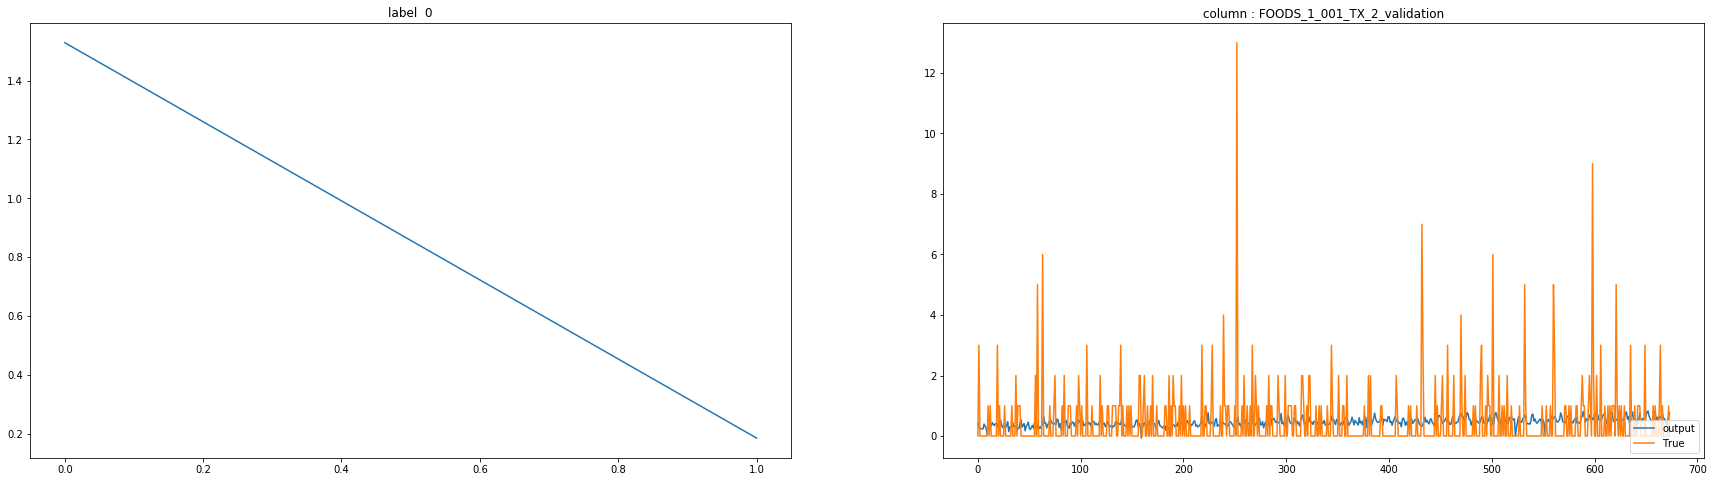

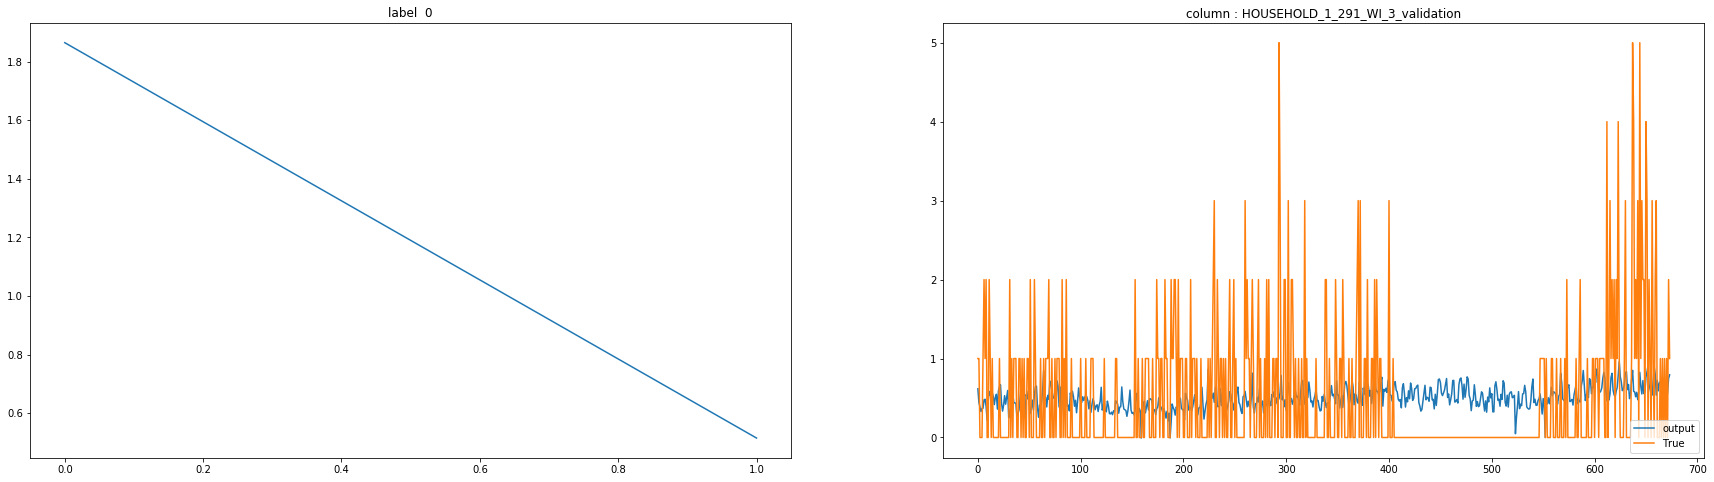

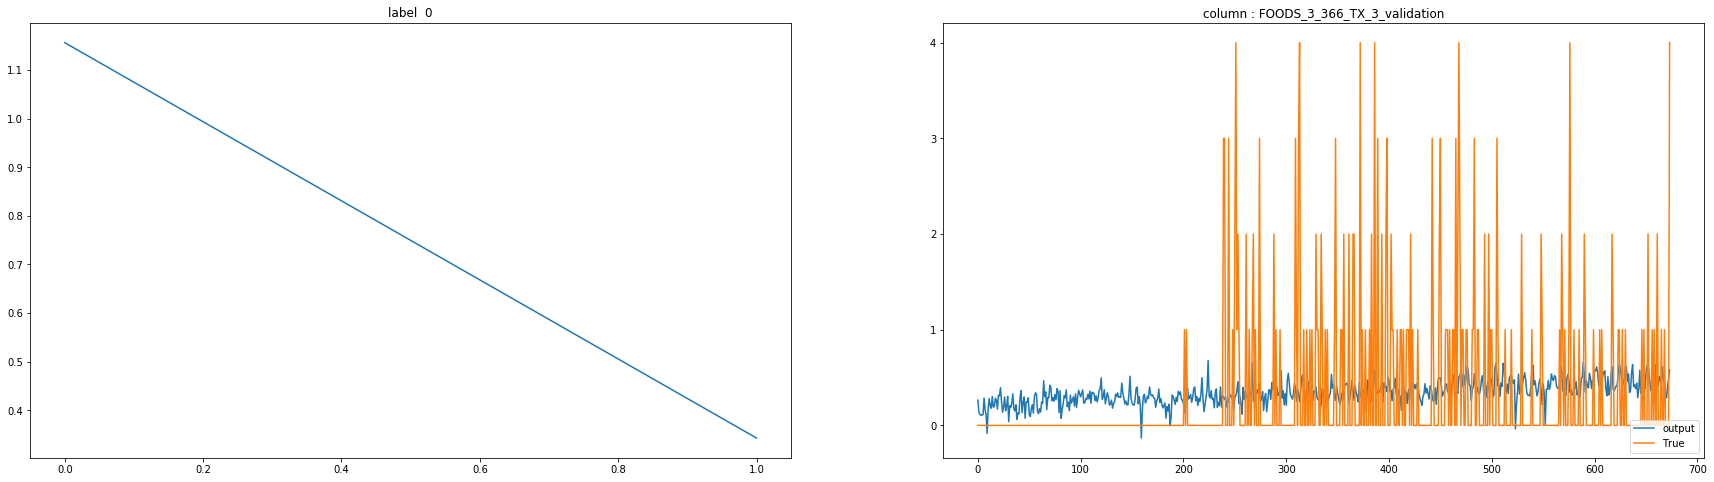

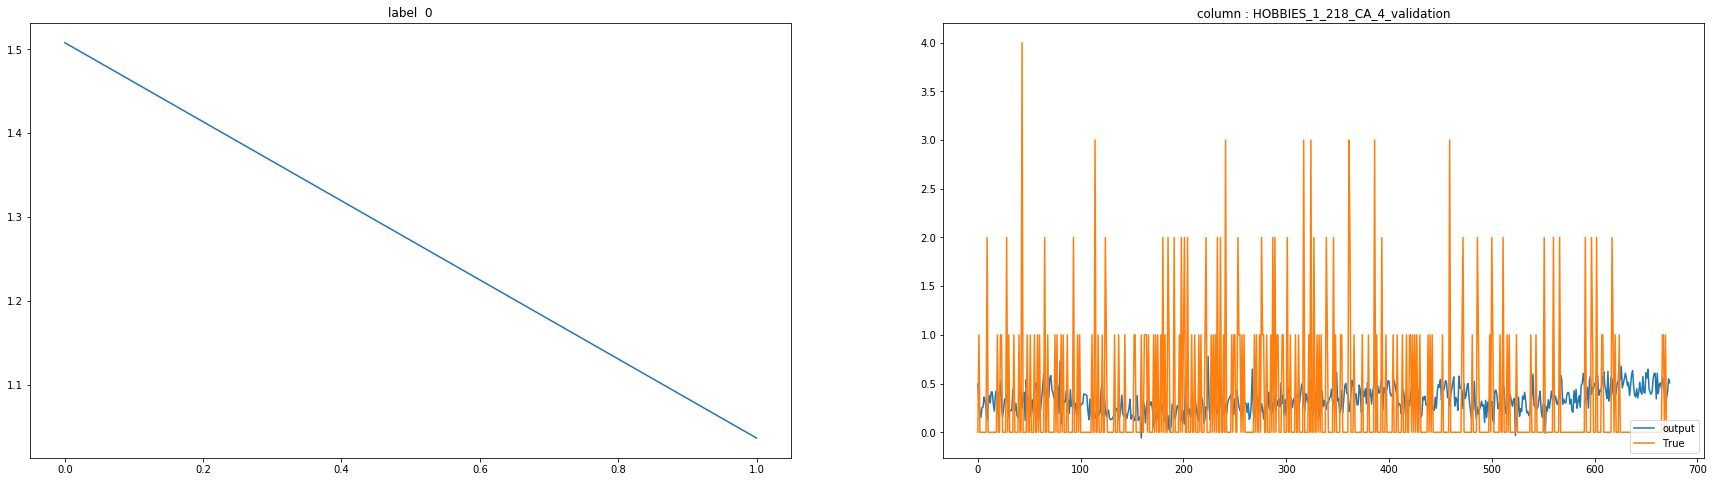

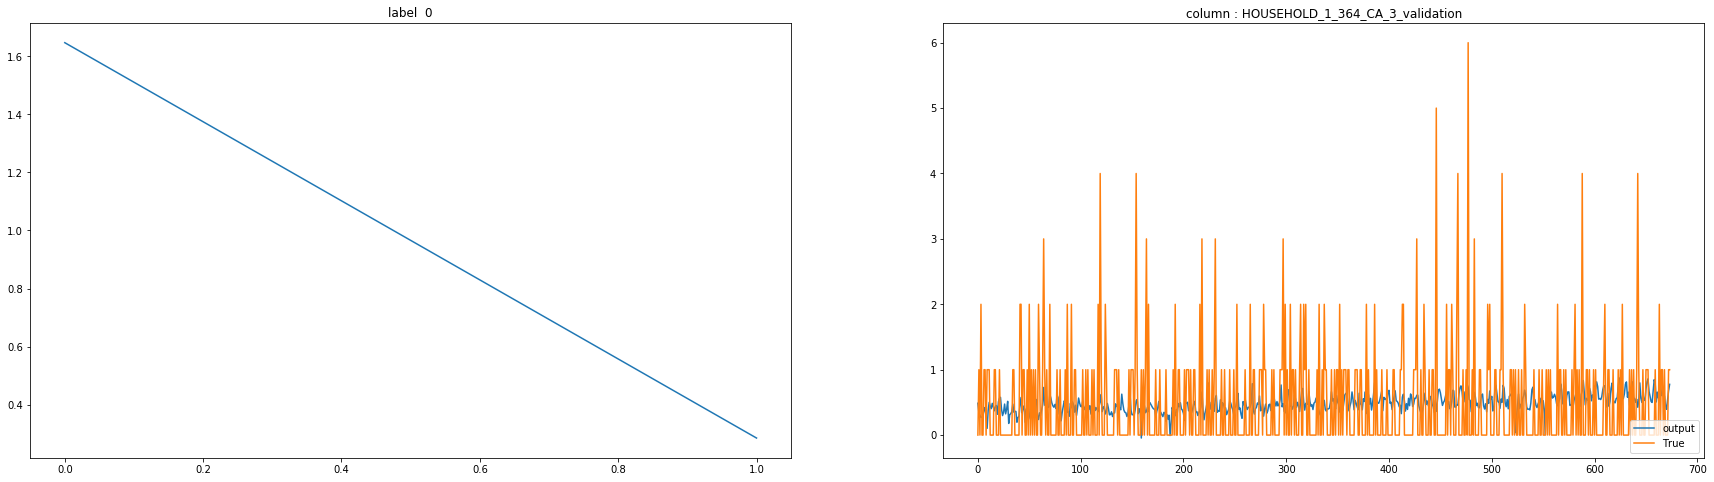

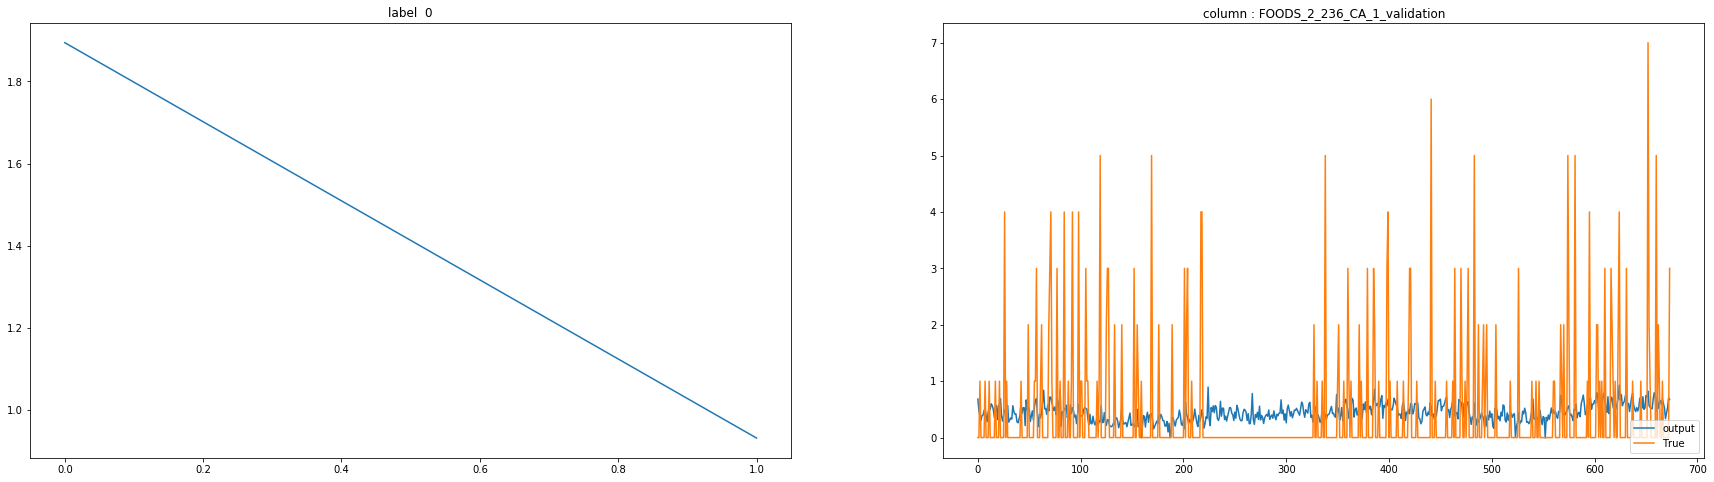

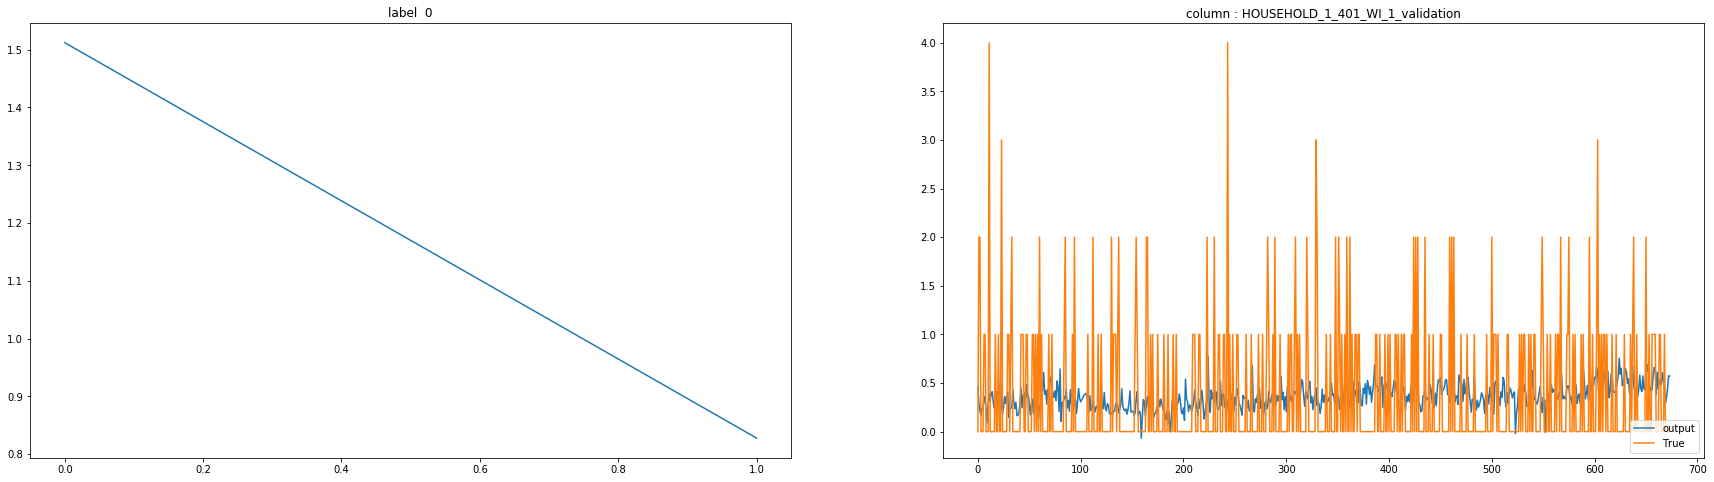

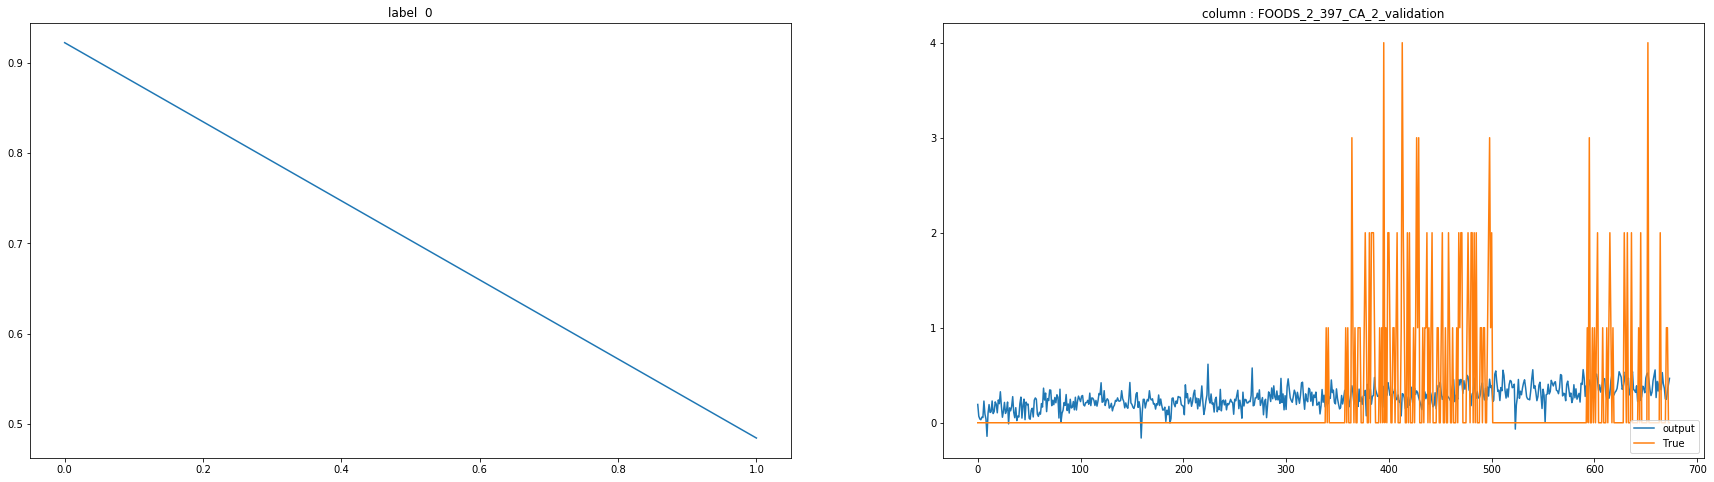

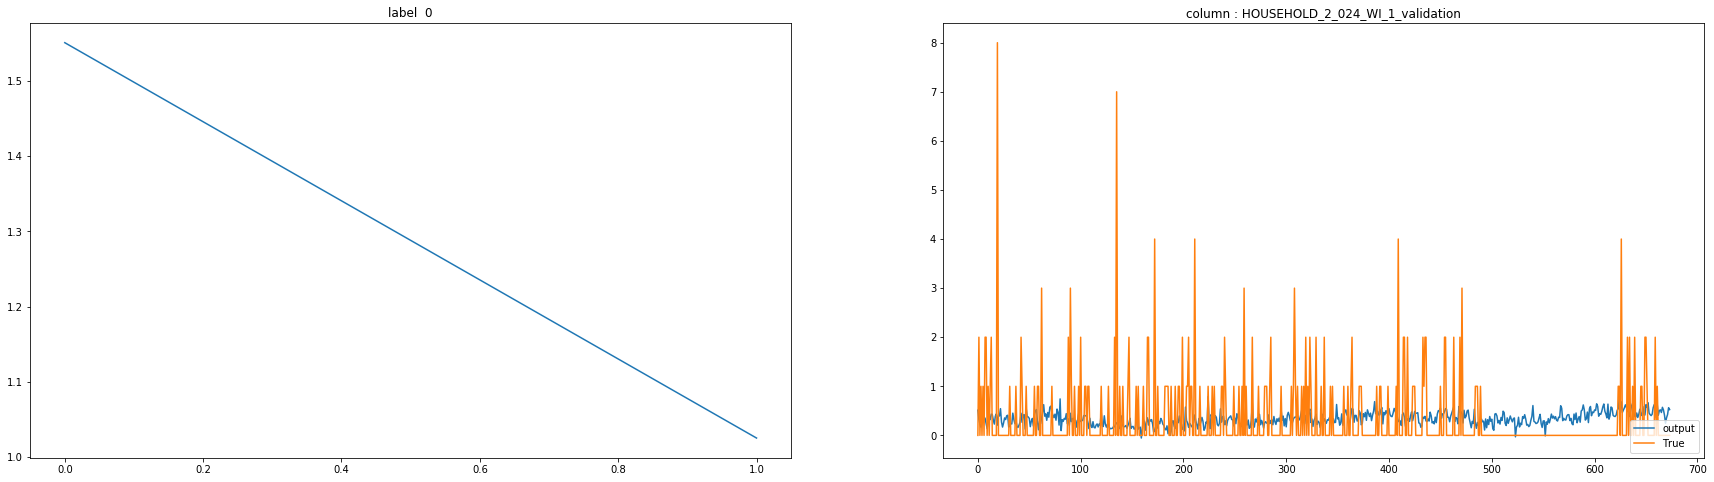

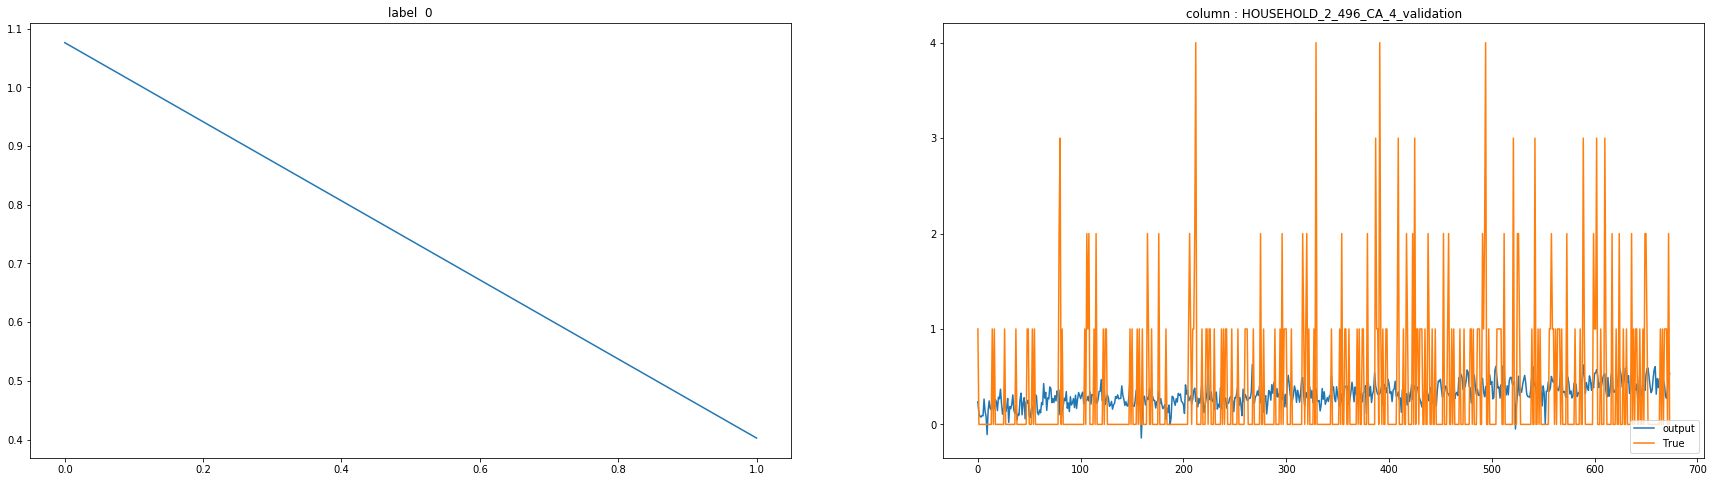

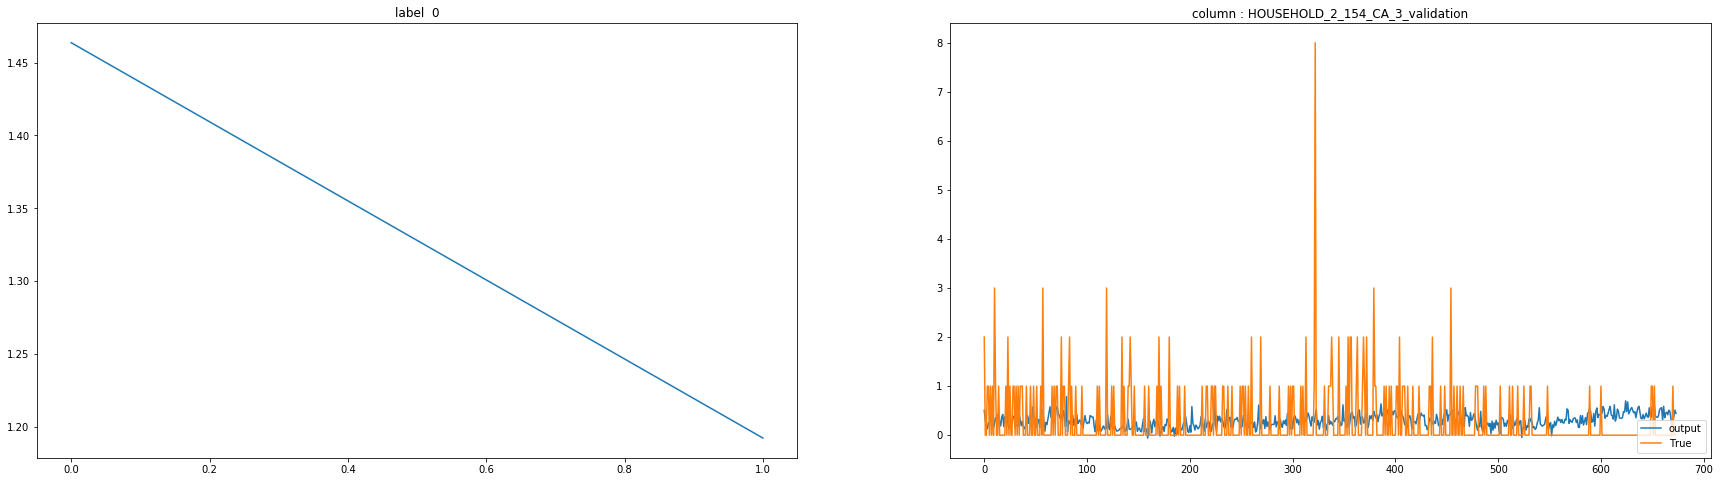

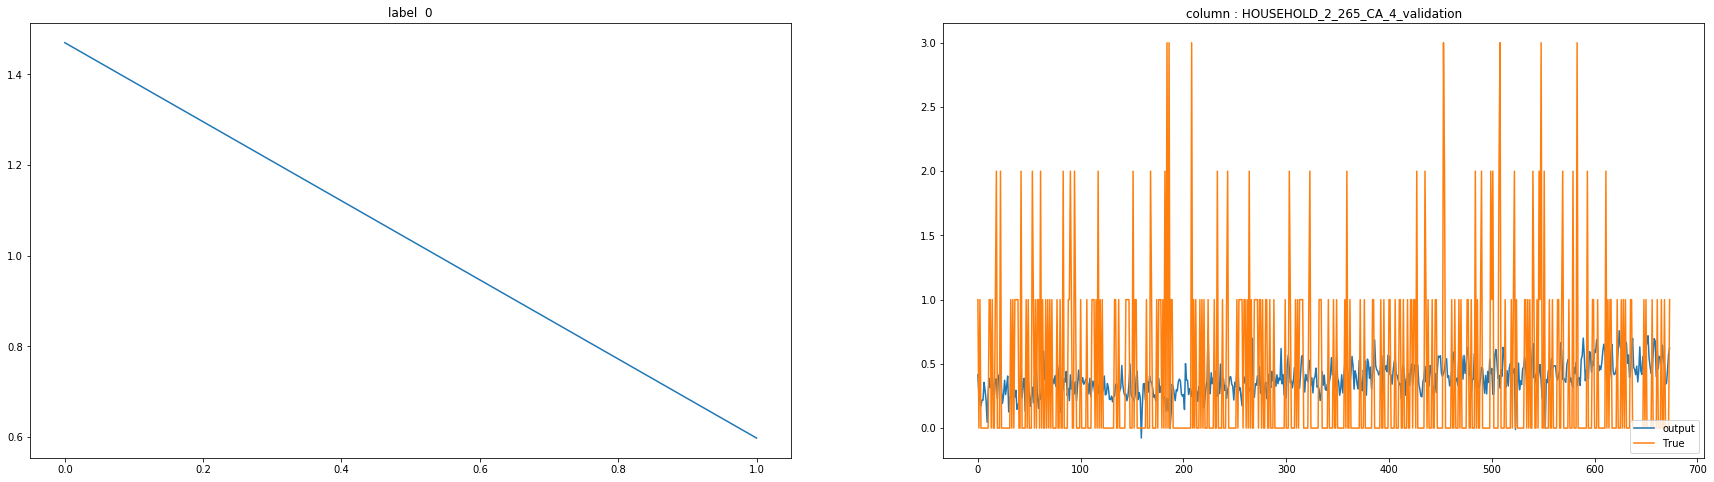

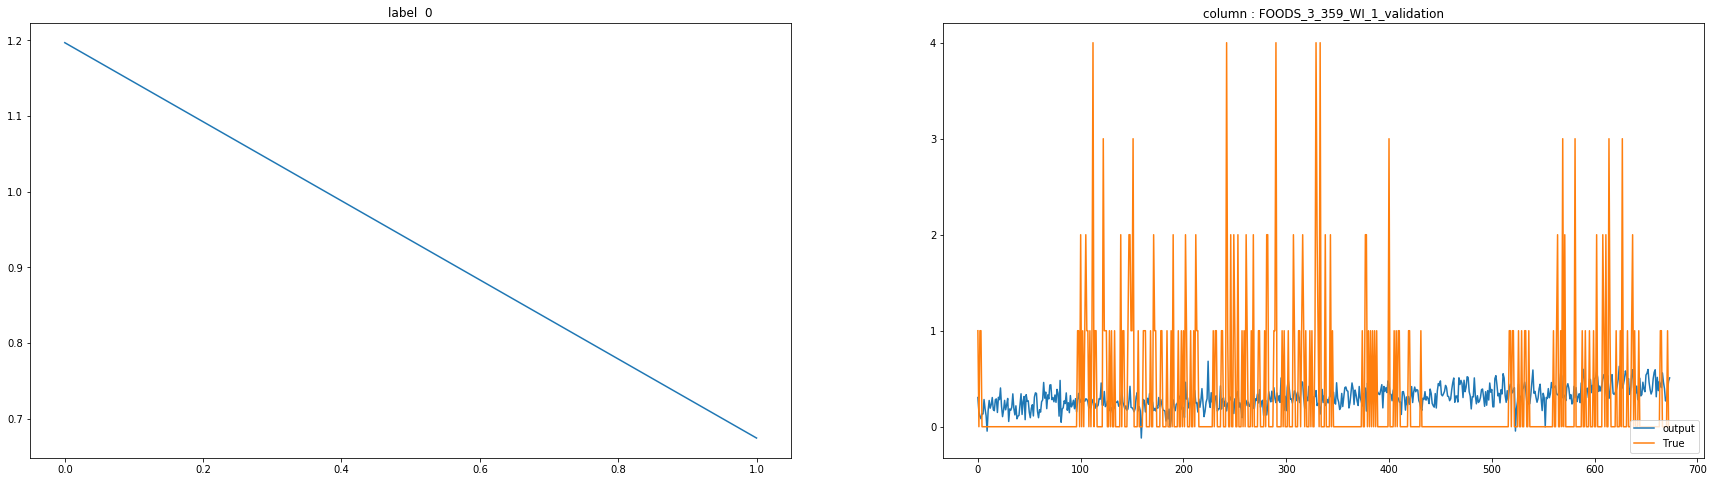

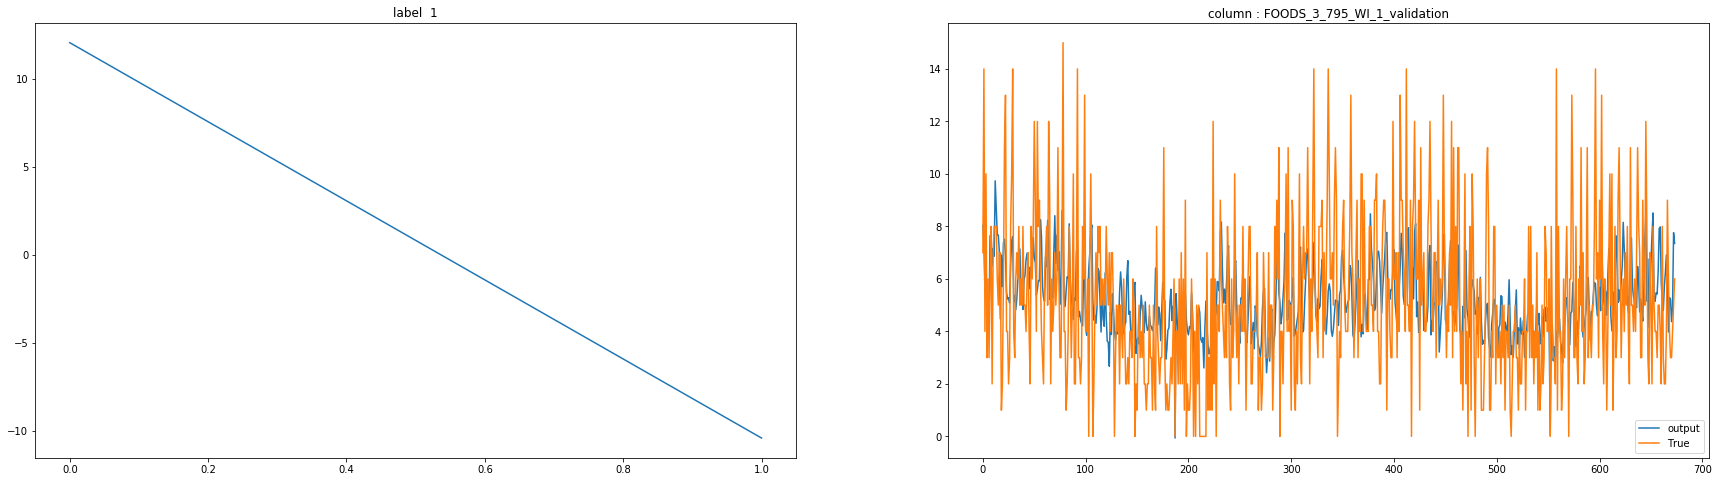

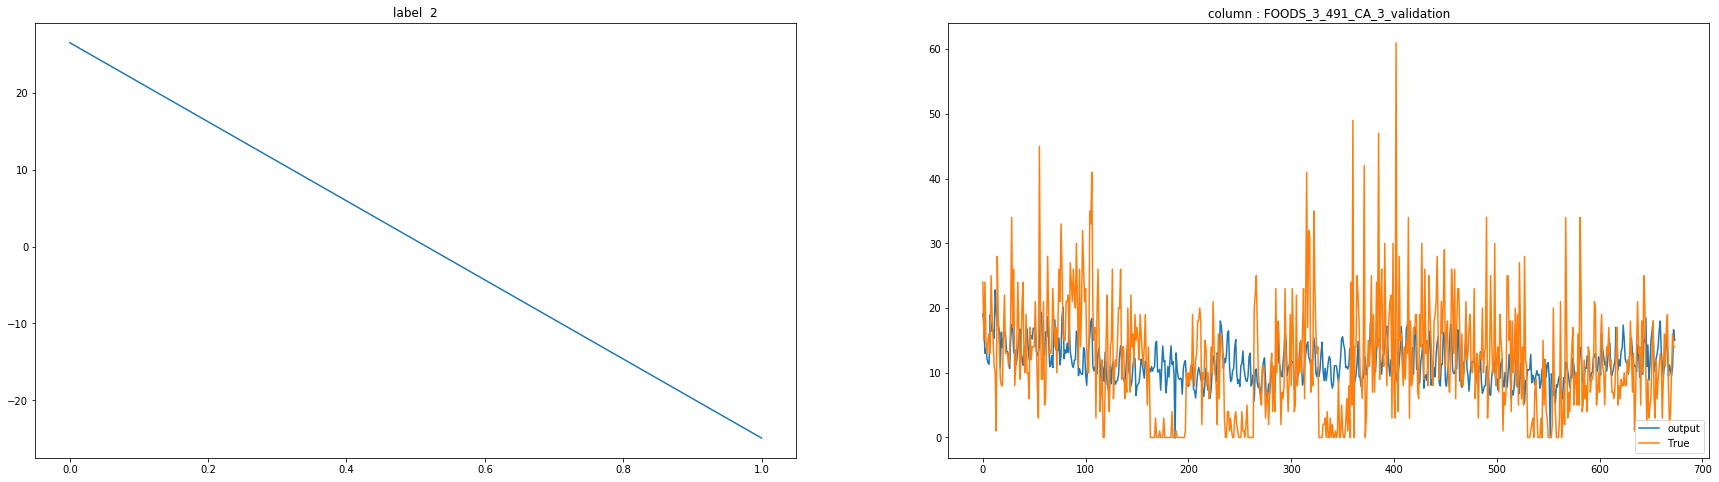

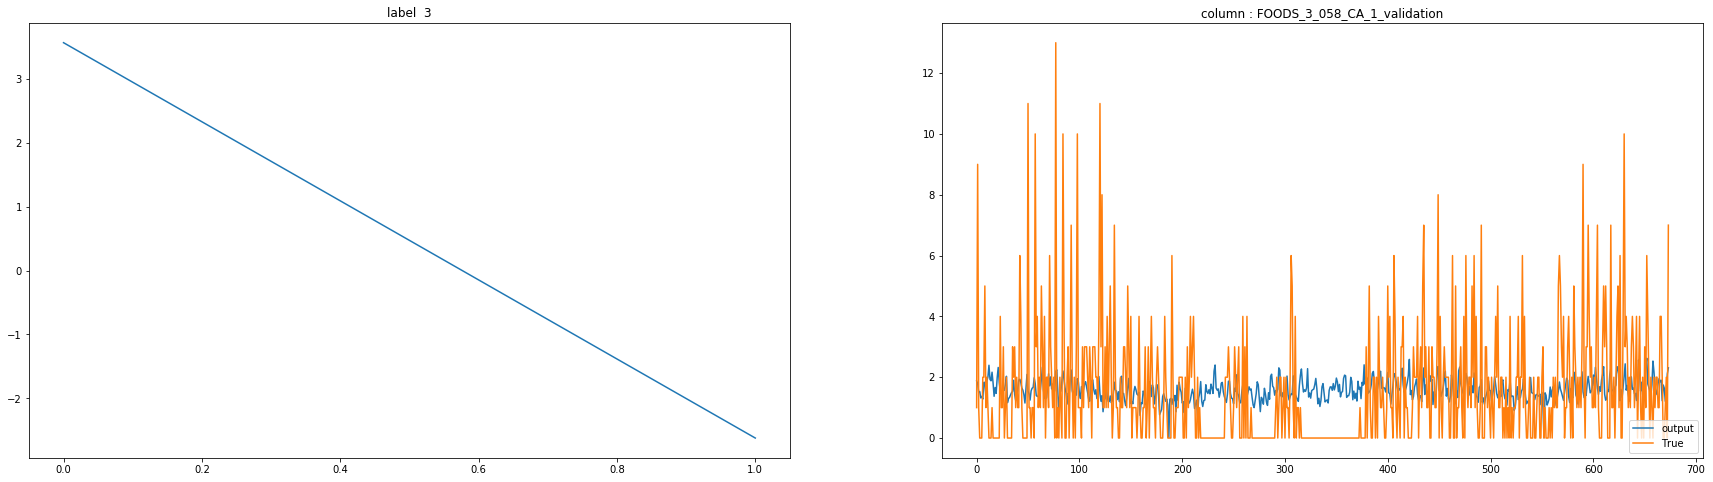

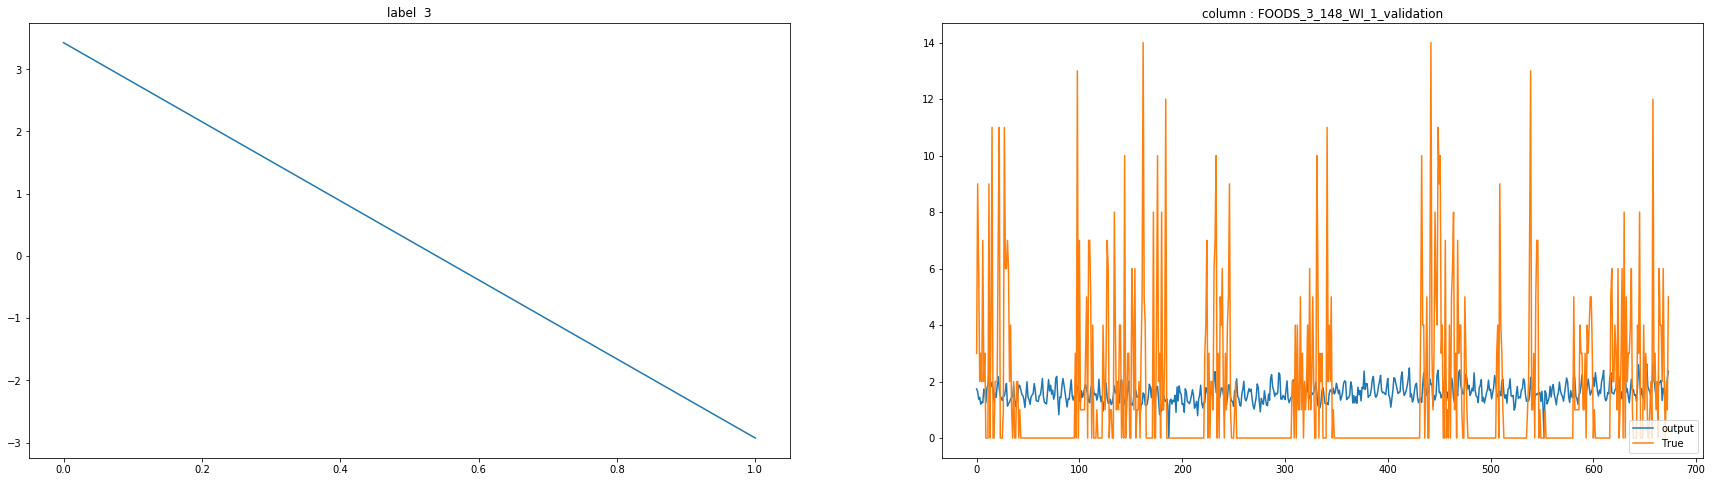

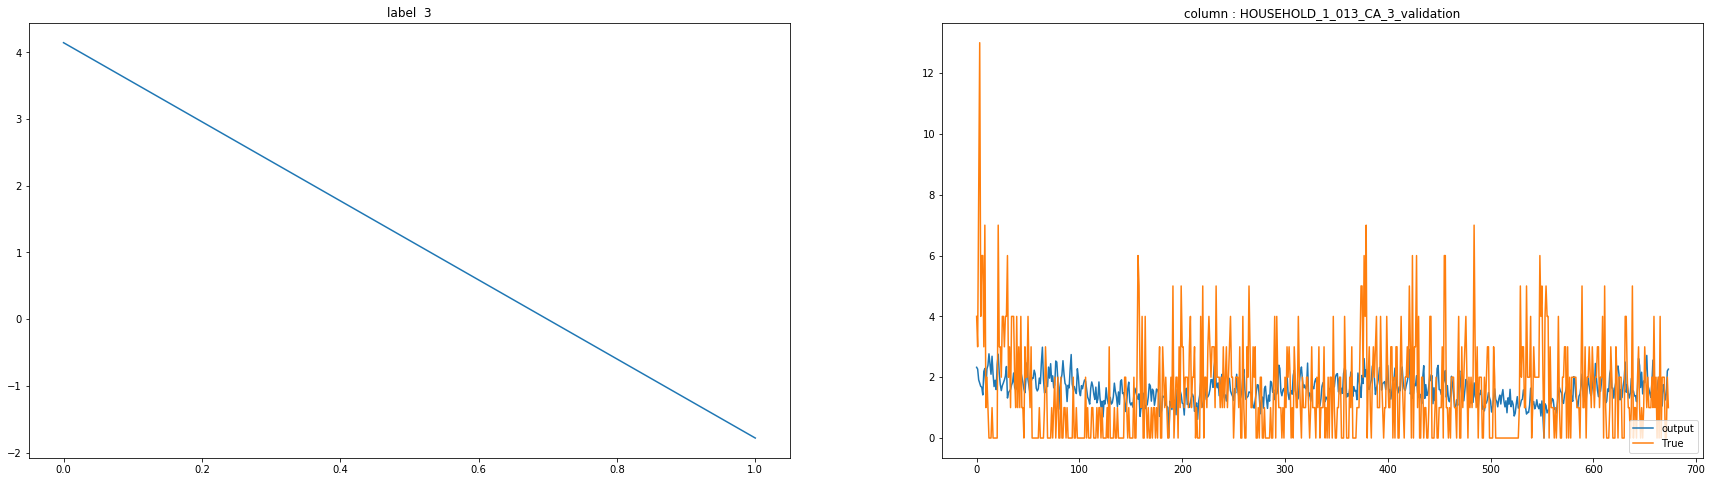

KeyboardInterrupt: 

In [64]:
for label in range(10):
    for i in df[df.label==label].index:
        _true = val_true[i]
        tmp_out1 = out1[i]
        tmp_out2 = out2[i]


        plt.figure(figsize=(30,8))
        plt.subplot(1,2,1)
        plt.plot(tmp_out1)
        plt.title(f'label  {label}')
        plt.subplot(1,2,2)
        plt.plot(tmp_out2, label='output')
        plt.plot(_true, label='True')
        plt.legend(loc=4)
        t = df.loc[i,'column']
        plt.title(f'column : {t}')
        plt.show()